In [1]:
import sys
import os
file_path = os.path.abspath('__file__')
print(file_path)
# file_path = 'c:\\Users\\RushiS\\Data-Efficient-Reinforcement-Learning-with-Probabilistic-Model-Predictive-Control'
# sys.path.append(file_path)
# sys.path.append(os.path.join(os.path.dirname(file_path), '../../'))
# sys.path.append(file_path)
import gym

from rl_gp_mpc.config_classes.visu_config import VisuConfig
from rl_gp_mpc.run_env_function import run_env
from examples.double_integrator.config_double_integrator import get_config

import torch


c:\Users\RushiS\Data-Efficient-Reinforcement-Learning-with-Probabilistic-Model-Predictive-Control\examples\double_integrator\__file__


# Double Integrator Environment 

In [13]:
import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np
import random
from os import path


class DoubIntEnv(gym.Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 24
    }

    def __init__(self,m=1,c=0, target_state = np.array([[5],[0]])):

        self.m = m
        self.c = c

        self.dt = 0.1
        self.map_limit = 2
        self.dense_parameter = 20
        mapq, mapdq = np.meshgrid(np.linspace(-self.map_limit, self.map_limit, self.dense_parameter)
                                 , np.linspace(-self.map_limit, self.map_limit, self.dense_parameter))

        self.observation_space_low = np.array([-self.map_limit, -self.map_limit])
        self.observation_space_high = np.array([self.map_limit, self.map_limit])
        self.seed()
        self.viewer = None
        self.state = None
        self.ep_limit = 1000
        self.umin = -1.
        self.umax = 1.
        self.steps_beyond_done = None
        self.action_space = spaces.Box(low=np.array([self.umin]),
                               high=np.array([self.umax]),
                               dtype=np.float32)
        self.target_state = target_state
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_discrete(self, s):
        dis_state = (((s - self.observation_space_low)
                     /(self.observation_space_high - self.observation_space_low))
                    *self.dense_parameter)

        return dis_state.astype(np.int)

    def step(self, act):
        
        
        
        q, q_dot = self.state
        dt = self.dt
        u = act
        q = q + dt*q_dot
        q_dot = q_dot + q_dot*(-self.c/self.m) + (1/self.m)*dt*u
        self.last_u = u
        
        self.state = (np.array([q, q_dot[0]]))

        done = False

        # if (abs(q) <= 0.1) and (abs(q_dot) <= 0.1):
        #     cost = 10.0
        #     done = True
        
        # else:
        #     cost = -abs(q) - abs(q_dot)
        #     self.ep_count +=1

        if np.linalg.norm(self.target_state - self.state) <=0.1:
            done = True
            
        cost = -abs(q) - abs(q_dot)
        self.ep_count +=1

        if self.ep_count >= self.ep_limit:
            done = True

        if abs(q) >= (self.map_limit):
            cost = -abs(q) - abs(q_dot)
            done = True

        return np.array(self.state), cost, done, {}

    def reset(self):

        self.steps_beyond_done = None
        states = [np.array([self.map_limit - 0.1, 0])
                  , np.array([-self.map_limit + 0.1, 0])
                  ]
        # self.state = (random.choice(states))
        self.state = (np.array([0,0]))
        self.ep_count = 0
        return np.array(self.state)
        

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        world_width = self.map_limit * 2
        scale = screen_width/world_width
        carty = 200  # TOP OF CART
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
            axleoffset = cartheight / 4.0
            cart = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)

            self.track = rendering.Line((0, carty), (screen_width, carty))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

            self.goal = rendering.Line((screen_width/2, 0), (screen_width, screen_height))
            self.goal.set_color(0, 0, 255)

        if self.state is None:
            return None

        x = self.state
        cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)

        return self.viewer.render(return_rgb_array=mode == 'rgb_array')

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

# Rollout

In [3]:
import os
import sys
file_path = os.path.abspath('__file__')
# print(file_path)
# file_path = 'c:\\Users\\RushiS\\Data-Efficient-Reinforcement-Learning-with-Probabilistic-Model-Predictive-Control'
# sys.path.append(file_path)
sys.path.append(os.path.join(os.path.dirname(file_path), '../../'))
sys.path.append(os.path.join(os.path.dirname(file_path), '../../../PILCO-gpytorch/'))
from pilco.models import PILCO
from examples.utils import rollout, policy

env = DoubIntEnv()

obs = env.reset()

X, Y = rollout(env=env, pilco=None, random=True, verbose = False,render=False, timesteps=100)
# print(X,Y)
for i in range(1, 10):
    X_, Y_ = rollout(env=env, pilco=None, random=True,verbose = False,render=False,  timesteps=100)
    X = np.vstack((X, X_))
    Y = np.vstack((Y, Y_))
env.close()

state_dim = Y.shape[1]
control_dim = X.shape[1] - state_dim


Starting State:
 [0 0]
Starting State:
 [0 0]
Starting State:
 [0 0]
Starting State:
 [0 0]
Starting State:
 [0 0]
Starting State:
 [0 0]
Starting State:
 [0 0]
Starting State:
 [0 0]
Starting State:
 [0 0]
Starting State:
 [0 0]


c:\Users\RushiS\anaconda3\envs\gp_rl_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Controller, Cost function and GP transition model

In [4]:
# path= "/mnt/c/Users/RushiS/OneDrive - Northeastern University/CS5180_RL/Project/PILCO-gpytorch"
import sys
sys.path.append(os.path.join(os.path.dirname(file_path), '../../../PILCO-gpytorch/'))
from pilco.rewards import ExponentialReward
from pilco.controllers import RbfController, LinearController


controller = RbfController(state_dim,control_dim,100,max_action = 1)
R = ExponentialReward(state_dim=state_dim,
                      t=np.array([5, 0]))

C:\Users\RushiS\PILCO-gpytorch\pilco\controllers.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = Parameter(torch.tensor(X).float().cuda(),requires_grad=True)
C:\Users\RushiS\PILCO-gpytorch\pilco\controllers.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = Parameter(torch.tensor(Y).float().cuda(),requires_grad=True)


In [5]:
from rl_gp_mpc.control_objects.models.gp_model import GpStateTransitionModel
from rl_gp_mpc.config_classes.model_config import ModelConfig
model_config = ModelConfig(
		gp_init = {
            "noise_covar.noise": [1e-5, 1e-5],
            "base_kernel.lengthscale": [0.5, 0.5],
            "outputscale": [5e-2, 5e-2]
		},
		min_std_noise=1e-3,
		max_std_noise=1e-2,
		min_outputscale=1e-5,
		max_outputscale=0.95,
		min_lengthscale=4e-3,
		max_lengthscale=25.0,
		min_lengthscale_time=10,
		max_lengthscale_time=10000,
		init_lengthscale_time=100,
		include_time_model=False,
	)
transition_model = GpStateTransitionModel(config=model_config, 
                       dim_state=state_dim,
                       dim_action=control_dim)




In [6]:
#Debugging function in ~\Data-Efficient-Reinforcement-Learning-with-Probabilistic-Model-Predictive-Control\rl_gp_mpc\control_objects\models\gp_model.py:430, in calculate_factorizations(x, y, models)
#RuntimeError: Expected b and A to have the same dtype, but found b of type Float and A of type Double instead.
#iK = torch.cholesky_solve(batched_eye, L)
#batched_eye.dtype = float32
#L.dtpye = float64
def calculate_factorizations(x:torch.Tensor, y:torch.Tensor, models: "list[ExactGPModelMonoTask]"):
        """
        Compute iK and beta using the points in memory, which are needed to make predictions with the gaussian processes.
        These two variables only depends on data in memory, and not on input distribution,
        so they separated from other computation such that they can be computed outside the optimisation function,
        which is computed multiple times at each iteration

        Function inspired from
        https://github.com/nrontsis/PILCO/blob/6a962c8e4172f9e7f29ed6e373c4be2dd4b69cb7/pilco/models/mgpr.py#L81,
        reimplemented from tensorflow to pytorch
        Args:
            x (torch.Tensor): matrix containing the states and actions. Dim=(Nm, Ns + Na + Nc)
            y (torch.Tensor): matrix containing the states change. Dim=(Nm, Ns)
            models (list of gpytorch.models.ExactGP): list containing the gp models used to predict each state change.
                                                        Len=Ns
            Ns: number of states
            Na: number of actions
            Nc: number of context variables. At the moment, only 1 if time used
            Nm: number of points in memory

        Returns:
            iK (torch.Tensor): needed by the gaussian processes models to compute the predictions
            beta (torch.Tensor): needed by the gaussian processes models to compute the predictions

        """
        K = torch.stack([model.covar_module(x).evaluate() for model in models])
        batched_eye = torch.eye(K.shape[1]).repeat(K.shape[0], 1, 1).double()
        L = torch.linalg.cholesky(K + torch.stack([model.likelihood.noise for model in models])[:, None] * batched_eye)
        print(L.dtype)
        print(batched_eye.dtype)
        print(K.dtype)
        print(x.shape)
        print(K.shape)
        iK = torch.cholesky_solve(batched_eye, L)
        Y_ = (y.t())[:, :, None]
        beta = torch.cholesky_solve(Y_, L)[:, :, 0]
        return iK, beta
calculate_factorizations(torch.from_numpy(X),torch.from_numpy(Y),transition_model.models)

torch.float64
torch.float64
torch.float64
torch.Size([1000, 3])
torch.Size([2, 1000, 1000])


(tensor([[[ 9.8712e+04,  5.0150e+01,  1.5766e+01,  ...,  1.5687e+02,
           -1.9675e+01,  3.0360e+02],
          [ 5.0150e+01,  9.8461e+04,  1.5596e+02,  ..., -1.9008e+02,
            9.5719e+01,  4.7928e+00],
          [ 1.5766e+01,  1.5596e+02,  9.7424e+04,  ...,  4.5078e+01,
           -1.1080e+03, -1.3264e+01],
          ...,
          [ 1.5687e+02, -1.9008e+02,  4.5078e+01,  ...,  9.4396e+04,
           -2.6680e+01, -7.3594e+01],
          [-1.9675e+01,  9.5719e+01, -1.1080e+03,  ..., -2.6680e+01,
            9.6912e+04, -3.1449e+01],
          [ 3.0360e+02,  4.7928e+00, -1.3264e+01,  ..., -7.3594e+01,
           -3.1449e+01,  9.3717e+04]],
 
         [[ 9.8712e+04,  5.0150e+01,  1.5766e+01,  ...,  1.5687e+02,
           -1.9675e+01,  3.0360e+02],
          [ 5.0150e+01,  9.8461e+04,  1.5596e+02,  ..., -1.9008e+02,
            9.5719e+01,  4.7928e+00],
          [ 1.5766e+01,  1.5596e+02,  9.7424e+04,  ...,  4.5078e+01,
           -1.1080e+03, -1.3264e+01],
          ...,
    

In [5]:
from rl_gp_mpc.config_classes.training_config import TrainingConfig
training_config = TrainingConfig(
		lr_train=7e-3,
		iter_train=20,
		training_frequency=60,
		clip_grad_value=1e-3,
		print_train=True,
		step_print_train=1
	)
training_config.lr_train, 
training_config.iter_train, 
training_config.clip_grad_value,
training_config.print_train, 
training_config.step_print_train

1

# Optimizing GP model on experiences collected from Rollouts

In [6]:
transition_model.prepare_inference(torch.from_numpy(X), torch.from_numpy(Y))
saved_state = transition_model.save_state()
print(saved_state.to_tensors())
transition_model.train(saved_state,
                       training_config.lr_train, 
                        training_config.iter_train, 
                        training_config.clip_grad_value,
                        training_config.print_train, 
                        training_config.step_print_train)

NameError: name 'transition_model' is not defined

# Optimizing Controller 
* Evaluate Policy loss $J^{\pi}(\theta)$
* Minimize Policy loss by updating parameter $\theta$ using gradient computed by optimizer $\frac{dJ^{\pi}(\theta)}{d\theta}$

$J^{\pi}(\psi) = \sum_{t=0}^{T} \gamma^{t} \mathbb{E}_{x_t} [c(x_t)]$ 
 
where , 
* $\pi$ is a policy parametrized by $\theta$. We will choose a *RBF Network* to represent the policy or controller.
* $c(x_t) = 1 - exp(-\frac{1}{2\sigma_c^2} {||x - x_{target}||}^2)$. We will choose a *Exponentially Saturated* cost function $c(x_t) \in [0,1]$

$ \frac{dJ^{\pi}(\psi)}{d\psi} = \sum_{t=0}^{T} \frac{d}{d\psi} \mathbb{E}_{x_t} [c(x_t)]$ 

In [8]:
def prediction(env,controller,R,transition_model,m_init,S_init,len_horizon=100):


    dim_input_model = state_dim +control_dim 
    action = controller.compute_action(m_init,S_init)[0][0][0]
    # print(action)
    act_env = np.array([action.cpu().detach().numpy()])
    # print(action.cpu().detach().numpy())

    states_mu_pred = torch.empty((len_horizon + 1, len(m_init)))
    states_var_pred = torch.empty((len_horizon + 1, transition_model.dim_state, transition_model.dim_state))
    states_mu_pred[0] = m_init
    states_var_pred[0] = S_init

    # Rewards/Costs
    reward = torch.zeros(1).float().cuda()

    # Comparing result with actual environment
    X = []; Y = []
    x = env.reset()

    for idx_time in range(1, len_horizon + 1):
        # print("time step ",idx_time)
        action = controller.compute_action(states_mu_pred[idx_time - 1].cuda(),states_var_pred[idx_time - 1].cuda())[0][0][0]
        
        input_mean = torch.empty((dim_input_model,))
        input_mean[:state_dim] = states_mu_pred[idx_time - 1]
        input_mean[state_dim:(state_dim + control_dim)] = action

        input_var = torch.zeros((dim_input_model, dim_input_model))
        input_var[:state_dim, :state_dim] = states_var_pred[idx_time - 1]

        state_change, state_change_var, v = transition_model.predict_next_state_change(input_mean.double(), input_var.double())
        # state_change= state_change.detach(); state_change_var = state_change_var.detach(); v =v.detach()

        states_mu_pred[idx_time] = states_mu_pred[idx_time - 1] + state_change
        states_var_pred[idx_time] = state_change_var + states_var_pred[idx_time - 1] + \
                                    input_var[:states_var_pred.shape[1]].double() @ v.double() + \
                                    v.t() @ input_var[:states_var_pred.shape[1]].t().double()
        
        # Cost Calculation for Trajectory
        reward = reward + R.compute_reward(states_mu_pred[idx_time].cuda(),states_var_pred[idx_time].cuda())[0]
        # Comparing result with actual environment
        x_new, _, done, _ = env.step(act_env)
        X.append(np.hstack((x, act_env)))
        Y.append(x_new - x)
        x = x_new
    return states_mu_pred,states_var_pred,reward,X,Y



In [3]:
class ExponentialSchedule:
    def __init__(self, value_from, value_to, num_steps):
        """Exponential schedule from `value_from` to `value_to` in `num_steps` steps.

        $value(t) = a \exp (b t)$

        :param value_from: initial value
        :param value_to: final value
        :param num_steps: number of steps for the exponential schedule
        """
        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps

        # YOUR CODE HERE:  determine the `a` and `b` parameters such that the schedule is correct
        self.a = self.value_from
        self.b = (np.log(self.value_to)-(np.log(self.a)))/(self.num_steps-1)

    def value(self, step) -> float:
        """Return exponentially interpolated value between `value_from` and `value_to`interpolated value between.

        returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == num_steps - 1 or more
            the exponential interpolation between `value_from` and `value_to`, if 0 <= steps < num_steps
        }

        :param step:  The step at which to compute the interpolation.
        :rtype: float.  The interpolated value.
        """

        # YOUR CODE HERE:  implement the schedule rule as described in the docstring,
        # using attributes `self.a` and `self.b`.
        
        if step<=0:
            value = self.value_from
        elif step >= self.num_steps -1:
            value = self.value_to
        else:
            value = self.a*np.exp(self.b*(step))
        
        return value
    
num_episodes = 15
eps = ExponentialSchedule(1.5, 1e-2, num_episodes)
lr = ExponentialSchedule(5e-2, 1e-2, num_episodes)
lr.value(10)

0.015838196087665797

In [4]:
def env_rollout(env,controller,horizon):
    # Comparing result with actual environment
    X = []; Y = []
    x = env.reset()

    s = torch.zeros((len(x), len(x))).float().cuda()
    for idx_time in range(1, horizon + 1):
        action = controller.compute_action(torch.from_numpy(x).float().cuda(),s)[0][0][0]
        act_env = np.array([action.cpu().detach().numpy()])
        x_new, _, done, _ = env.step(act_env)
        
        X.append(np.hstack((x, act_env)))
        Y.append(x_new - x)
        x = x_new
    return X,Y

In [8]:
import sys
sys.path.append(os.path.join(os.path.dirname(file_path), '../../../PILCO-gpytorch/'))
from pilco.rewards import ExponentialReward
from pilco.controllers import RbfController, LinearController

from rl_gp_mpc.control_objects.models.gp_model import GpStateTransitionModel
from rl_gp_mpc.config_classes.model_config import ModelConfig
from rl_gp_mpc.config_classes.training_config import TrainingConfig


class PILCO(torch.nn.Module):
    def __init__(self, X, Y, num_induced_points=None, horizon=100, controller=None,
                reward=None, m_init=None, S_init=None, name=None, model_config: ModelConfig = None,
                training_config:TrainingConfig = None):
        super(PILCO, self).__init__()
        self.X = X
        self.Y = Y
        self.state_dim = Y.shape[1]
        self.control_dim = X.shape[1] - Y.shape[1]
        self.transition_model = GpStateTransitionModel(config=model_config, 
                       dim_state=self.state_dim,
                       dim_action=self.control_dim)
        self.horizon = horizon
        self.training_config = training_config

        if controller is None:
            self.controller = RbfController(self.state_dim,self.control_dim,100,max_action = 1)
            # self.controller = LinearController(state_dim=self.state_dim, control_dim=self.control_dim)
        else:
            self.controller = controller

        if reward is None:
            self.reward = ExponentialReward(state_dim=self.state_dim,
                      t=np.array([1, 0]))
            self.reward_to_go = ExponentialReward(state_dim=self.state_dim -1,
                      t=np.array([1]))
        else:
            self.reward = reward

        if m_init is None or S_init is None:
            # If the user has not provided an initial state for the rollouts,
            # then define it as the first state in the dataset.
            self.m_init = X[0:1, 0:self.state_dim]
            self.S_init = np.diag(np.ones(self.state_dim) * 1e-6)
        else:
            self.m_init = m_init
            self.S_init = S_init
        self.optimizer = None
        self.best_reward = 0
        self.optimizer = None
        self.optim_lr = 1e-3
        self.best_loss = 0
        self.eps = 1e-2
        self.explore = -0.1
        self.gamma = 0.99
    
    def train(self):
        self.transition_model.prepare_inference(torch.from_numpy(self.X), torch.from_numpy(self.Y))
        saved_state = self.transition_model.save_state()
        self.transition_model.train(saved_state,
                            self.training_config.lr_train, 
                            self.training_config.iter_train, 
                            self.training_config.clip_grad_value,
                            self.training_config.print_train, 
                            self.training_config.step_print_train)
    
    def prediction(self,m_init,S_init):
        len_horizon=self.horizon
        self.transition_model.prepare_inference(torch.from_numpy(self.X), torch.from_numpy(self.Y))
        dim_input_model = self.state_dim +self.control_dim 
        # action = controller.compute_action(m_init,S_init)[0][0][0]
        # print(action)
        # act_env = np.array([action.cpu().detach().numpy()])
        # print(action.cpu().detach().numpy())

        states_mu_pred = torch.empty((len_horizon + 1, self.state_dim))
        # states_mu_pred.requires_grad = True
        states_var_pred = torch.empty((len_horizon + 1, self.state_dim, self.state_dim))
        # states_var_pred.requires_grad = True
        states_mu_pred[0] = m_init
        states_var_pred[0] = S_init

        # Rewards/Costs
        cost = torch.zeros(1).float().cuda()
        cost.requires_grad = True
        L_ = torch.empty((len_horizon )).cuda()
        S_ = torch.empty((len_horizon )).cuda()
        dLdm_ = torch.empty((len_horizon , self.state_dim)).cuda()
        dLds_ =torch.empty((len_horizon , self.state_dim,self.state_dim)).cuda()
        

        for idx_time in range(1, len_horizon + 1):
            # print("time step ",idx_time)
            action = self.controller.compute_action(states_mu_pred[idx_time - 1].cuda(),states_var_pred[idx_time - 1].cuda())[0][0][0]
            
            input_mean = torch.empty((dim_input_model,))
            input_mean[:self.state_dim] = states_mu_pred[idx_time - 1]
            input_mean[self.state_dim:(self.state_dim + self.control_dim)] = action
            #free up space for cuda
          
            input_var = torch.zeros((dim_input_model, dim_input_model))
            input_var[:self.state_dim, :self.state_dim] = states_var_pred[idx_time - 1]

            state_change, state_change_var, v = self.transition_model.predict_next_state_change(input_mean.double(), input_var.double())
            
            # state_change= state_change.detach(); state_change_var = state_change_var.detach(); v =v.detach()

            states_mu_pred[idx_time] = states_mu_pred[idx_time - 1] + state_change
            states_var_pred[idx_time] = state_change_var + states_var_pred[idx_time - 1] + \
                                        input_var[:states_var_pred.shape[1]].double() @ v.double() + \
                                        v.t() @ input_var[:states_var_pred.shape[1]].t().double()
            
           
            # Cost Calculation for Trajectory
            L,S, dLdm, dLds, dSdm, dSds = self.reward.compute_reward(states_mu_pred[idx_time].cuda(),states_var_pred[idx_time].cuda())
            L_[idx_time - 1] =  L 
            S_[idx_time - 1] =  S
            dLdm_[idx_time -1] = dLdm
            dLds_[idx_time- 1] = dLds

            cost = cost + self.gamma**(idx_time-1) *(L + self.explore*S)
            # cost = cost + self.gamma**(idx_time-1) *L 
        # reward = reward + self.reward.compute_reward(states_mu_pred[idx_time].cuda(),states_var_pred[idx_time].cuda())[0]
        return states_mu_pred,states_var_pred,cost
    
    def optimize_policy(self):
        maxiter = 12
        if self.optimizer is None:
            optimizer = torch.optim.Adam([
                            {'params':self.controller.parameters()},
                            ], lr=self.optim_lr)
        
            self.optimizer = optimizer
        
        self.optimizer.param_groups[0]['lr'] = self.optim_lr
        m_init = torch.from_numpy(self.m_init).cuda()
        S_init = torch.from_numpy(self.S_init).cuda()
        cost = torch.zeros(1).float().cuda()
        loss = 0
        dloss = 1
        
        
        for i in range(maxiter):
                    self.optimizer.zero_grad()
                    states_mu_pred,states_var_pred,cost = self.prediction(m_init,S_init)
                    # states_mu_pred = states_mu_pred.detach();states_var_pred= states_var_pred.detach()
                    # dloss = abs(loss-(-cost))
                    loss = -cost
                    # if loss<self.best_loss:
                    #     self.best_loss = loss
                    #     self.best_loss_controller = self.controller
                    # else:
                    #     break
                    loss.backward()
                    # plot_grad_flow_v2(self.controller.parameters())
                    print('(Optimize Policy: Iter %d/%d - Loss: %.3f )' % (i+1,maxiter,loss.item()))
                    self.optimizer.step()
    
    def add(self,X,Y):
        self.X = np.vstack((self.X, X))
        self.Y = np.vstack((self.Y, Y))

In [30]:
from examples.utils import rollout, policy
env = DoubIntEnv()

model_config = ModelConfig(
		gp_init = {
            "noise_covar.noise": [1e-5, 1e-5],
            "base_kernel.lengthscale": [0.5, 0.5],
            "outputscale": [5e-2, 5e-2]
			# "noise_covar.noise": [1e-5],
            # "base_kernel.lengthscale": [0.5],
            # "outputscale": [5e-2]
		},
		min_std_noise=1e-3,
		max_std_noise=1e-2,
		min_outputscale=1e-5,
		max_outputscale=0.95,
		min_lengthscale=4e-3,
		max_lengthscale=25.0,
		min_lengthscale_time=10,
		max_lengthscale_time=10000,
		init_lengthscale_time=100,
		include_time_model=False,
	)
training_config = TrainingConfig(
		lr_train=7e-3,
		iter_train=20,
		training_frequency=60,
		clip_grad_value=1e-3,
		print_train=False,
		step_print_train=10
	)
X, Y = rollout(env=env, pilco=None, random=True, verbose = False,render=False, timesteps=100)
# print(X,Y)
for i in range(1, 10):
    X_, Y_ = rollout(env=env, pilco=None, random=True,verbose = False,render=False,  timesteps=100)
    X = np.vstack((X, X_))
    Y = np.vstack((Y, Y_))
env.close()
pilco = PILCO(X,Y,model_config=model_config,training_config=training_config,horizon=50)
pilco.controller.max_action = 1
pilco.optim_lr = 5e-2
pilco.train()
# pilco.controller.randomize()
# pilco.optimize_policy()

c:\Users\RushiS\anaconda3\envs\gp_rl_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Starting State:
 [0 0]
Env Done... 68
Starting State:
 [0 0]
Starting State:
 [0 0]
Starting State:
 [0 0]
Env Done... 55
Starting State:
 [0 0]
Env Done... 57
Starting State:
 [0 0]
Env Done... 58
Starting State:
 [0 0]
Starting State:
 [0 0]
Env Done... 91
Starting State:
 [0 0]
Starting State:
 [0 0]
training process - model 0 - time train 8.582458 - output_scale: 0.72545445 - lengthscales: [[ 9.901  7.034 23.759]] - noise: [0.]
training process - model 1 - time train 12.787459 - output_scale: 0.57024133 - lengthscales: [[7.012 1.412 6.437]] - noise: [0.]
training process - previous marginal log likelihood: [-3.123 -3.087] - new marginal log likelihood: [-4.105 -3.811]


In [59]:
from torch.nn import Module,Parameter
state_dim = 2
control_dim = 1
m_init = np.array([0,0])
S_init = np.diag(np.ones(state_dim) * 1e-6)
m_init = torch.from_numpy(m_init).cuda()
S_init = torch.from_numpy(S_init).cuda()
len_horizon=22

pilco.transition_model.prepare_inference(torch.from_numpy(X), torch.from_numpy(Y))

dim_input_model = state_dim +control_dim 


states_mu_pred = torch.empty((len_horizon + 1, state_dim)).cuda()
# states_mu_pred.requires_grad = True
states_var_pred = torch.empty((len_horizon + 1, state_dim, state_dim)).cuda()
# states_var_pred.requires_grad = True
states_mu_pred[0] = m_init
states_var_pred[0] = S_init

# Rewards/Costs
cost = torch.zeros(1).float().cuda()
cost.requires_grad = True

W = Parameter(torch.tensor(np.eye(state_dim)), requires_grad=True).float().cuda()
t = torch.tensor(np.zeros((1, 2)), requires_grad=True).float().cuda()

m,S = states_mu_pred[0], states_var_pred[0]


#LOSS
SW = S @ W

iSpW = W / torch.det(torch.eye(state_dim, dtype=torch.float32).cuda()  + SW)

L = 1 -torch.exp(-(m-t) @ iSpW @ torch.t(m-t)/2)/ \
                torch.sqrt(torch.det(torch.eye(state_dim, dtype=torch.float32).cuda() + SW))

L

tensor([[9.5367e-07]], device='cuda:0', grad_fn=<RsubBackward1>)

In [ ]:
state_dim = 2
control_dim = 1
m_init = X[0:1, 0:state_dim]
S_init = np.diag(np.ones(state_dim) * 1e-6)
len_horizon=22

pilco.transition_model.prepare_inference(torch.from_numpy(X), torch.from_numpy(Y))

dim_input_model = state_dim +control_dim 


states_mu_pred = torch.empty((len_horizon + 1, state_dim))
# states_mu_pred.requires_grad = True
states_var_pred = torch.empty((len_horizon + 1, state_dim, state_dim))
# states_var_pred.requires_grad = True
states_mu_pred[0] = m_init
states_var_pred[0] = S_init

# Rewards/Costs
cost = torch.zeros(1).float().cuda()
cost.requires_grad = True

W = Parameter(tensor(np.eye(state_dim)), requires_grad=True).float().cuda()
t = torch.tensor(np.zeros((1, 2)), requires_grad=True).float().cuda()


for idx_time in range(1, len_horizon + 1):
    # print("time step ",idx_time)
    action = controller.compute_action(states_mu_pred[idx_time - 1].cuda(),states_var_pred[idx_time - 1].cuda())[0][0][0]
    
    input_mean = torch.empty((dim_input_model,))
    input_mean[:state_dim] = states_mu_pred[idx_time - 1]
    input_mean[state_dim:(state_dim + control_dim)] = action
    #free up space for cuda
    
    input_var = torch.zeros((dim_input_model, dim_input_model))
    input_var[:state_dim, :state_dim] = states_var_pred[idx_time - 1]

    state_change, state_change_var, v = pilco.transition_model.predict_next_state_change(input_mean.double(), input_var.double())
    
    # state_change= state_change.detach(); state_change_var = state_change_var.detach(); v =v.detach()

    states_mu_pred[idx_time] = states_mu_pred[idx_time - 1] + state_change
    states_var_pred[idx_time] = state_change_var + states_var_pred[idx_time - 1] + \
                                input_var[:states_var_pred.shape[1]].double() @ v.double() + \
                                v.t() @ input_var[:states_var_pred.shape[1]].t().double()
    
    
    # Cost Calculation for Trajectory

    L,S, dLdm, dLds, dSdm, dSds = self.reward.compute_reward(states_mu_pred[idx_time].cuda(),states_var_pred[idx_time].cuda())
   

    cost = cost + self.gamma**(idx_time-1) *(L + self.explore*S)
    # cost = cost + self.gamma**(idx_time-1) *L 
# reward = reward + self.reward.compute_reward(states_mu_pred[idx_time].cuda(),states_var_pred[idx_time].cuda())[0]


C:\Users\RushiS\AppData\Local\Temp\ipykernel_14808\638831587.py:17: RuntimeWarning: divide by zero encountered in log
  self.b = (np.log(self.value_to)-(np.log(self.a)))/(self.num_steps-1)
C:\Users\RushiS\AppData\Local\Temp\ipykernel_14808\638831587.py:17: RuntimeWarning: invalid value encountered in log
  self.b = (np.log(self.value_to)-(np.log(self.a)))/(self.num_steps-1)


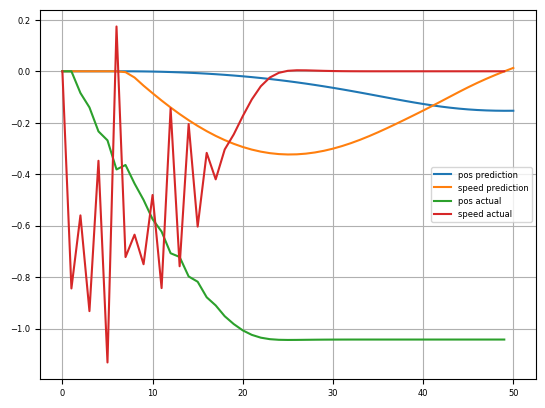

NaNs encountered when trying to perform matrix-vector multiplication
training process - model 0 - time train 5.347680 - output_scale: 0.049999997 - lengthscales: [[0.5 0.5 0.5]] - noise: [0.]
training process - model 1 - time train 17.106671 - output_scale: 0.049999997 - lengthscales: [[0.5 0.5 0.5]] - noise: [0.]
training process - previous marginal log likelihood: [-4.322 -4.271] - new marginal log likelihood: [-4.322 -4.271]
(Optimize Policy: Iter 1/12 - Loss: -30.843 )
(Optimize Policy: Iter 2/12 - Loss: -27.567 )
(Optimize Policy: Iter 3/12 - Loss: -25.211 )
(Optimize Policy: Iter 4/12 - Loss: -24.445 )
(Optimize Policy: Iter 5/12 - Loss: -25.115 )
(Optimize Policy: Iter 6/12 - Loss: -24.809 )
(Optimize Policy: Iter 7/12 - Loss: -25.564 )
(Optimize Policy: Iter 8/12 - Loss: -24.739 )
(Optimize Policy: Iter 9/12 - Loss: -24.576 )
(Optimize Policy: Iter 10/12 - Loss: -24.086 )
(Optimize Policy: Iter 11/12 - Loss: -24.250 )
(Optimize Policy: Iter 12/12 - Loss: -24.321 )


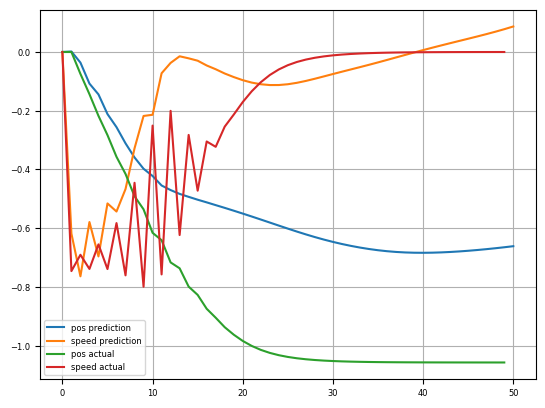

training process - model 0 - time train 6.561931 - output_scale: 0.049999997 - lengthscales: [[0.5 0.5 0.5]] - noise: [0.]
training process - model 1 - time train 48.903243 - output_scale: 0.049999997 - lengthscales: [[0.5 0.5 0.5]] - noise: [0.]
training process - previous marginal log likelihood: [-4.093 -4.019] - new marginal log likelihood: [-4.093 -4.019]
(Optimize Policy: Iter 1/12 - Loss: -32.116 )
(Optimize Policy: Iter 2/12 - Loss: -30.561 )
(Optimize Policy: Iter 3/12 - Loss: -30.328 )
(Optimize Policy: Iter 4/12 - Loss: -30.130 )
(Optimize Policy: Iter 5/12 - Loss: -29.864 )
(Optimize Policy: Iter 6/12 - Loss: -30.795 )
(Optimize Policy: Iter 7/12 - Loss: -30.517 )
(Optimize Policy: Iter 8/12 - Loss: -30.609 )
(Optimize Policy: Iter 9/12 - Loss: -29.083 )
(Optimize Policy: Iter 10/12 - Loss: -29.094 )
(Optimize Policy: Iter 11/12 - Loss: -29.290 )
(Optimize Policy: Iter 12/12 - Loss: -30.643 )


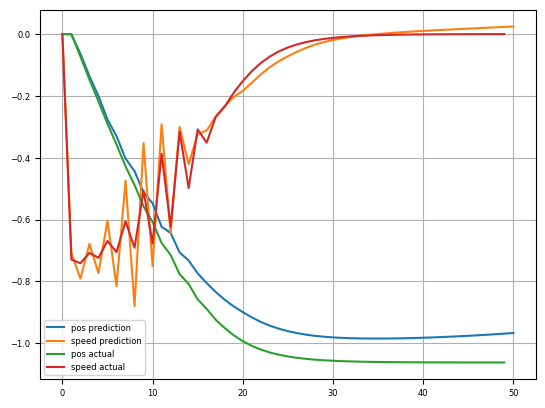

training process - model 0 - time train 5.221386 - output_scale: 0.93445593 - lengthscales: [[ 8.8    8.348 24.108]] - noise: [0.]
training process - model 1 - time train 19.936551 - output_scale: 0.8994943 - lengthscales: [[11.095 24.86  20.129]] - noise: [0.]
training process - previous marginal log likelihood: [-4.027 -3.971] - new marginal log likelihood: [-4.184 -5.237]
(Optimize Policy: Iter 1/12 - Loss: -32.204 )
(Optimize Policy: Iter 2/12 - Loss: -32.046 )
(Optimize Policy: Iter 3/12 - Loss: -32.062 )
(Optimize Policy: Iter 4/12 - Loss: -31.945 )
(Optimize Policy: Iter 5/12 - Loss: -32.007 )
(Optimize Policy: Iter 6/12 - Loss: -32.014 )
(Optimize Policy: Iter 7/12 - Loss: -31.994 )
(Optimize Policy: Iter 8/12 - Loss: -31.954 )
(Optimize Policy: Iter 9/12 - Loss: -31.930 )
(Optimize Policy: Iter 10/12 - Loss: -32.026 )
(Optimize Policy: Iter 11/12 - Loss: -32.100 )
(Optimize Policy: Iter 12/12 - Loss: -32.134 )


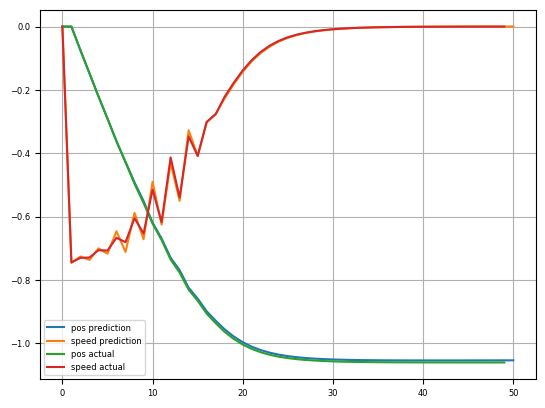

training process - model 0 - time train 6.651514 - output_scale: 0.9355565 - lengthscales: [[12.233  8.766 11.772]] - noise: [0.]
training process - model 1 - time train 12.671748 - output_scale: 0.049999997 - lengthscales: [[0.5 0.5 0.5]] - noise: [0.]
training process - previous marginal log likelihood: [-3.943 -3.845] - new marginal log likelihood: [-4.207 -3.845]
(Optimize Policy: Iter 1/12 - Loss: -32.258 )
(Optimize Policy: Iter 2/12 - Loss: -32.261 )
(Optimize Policy: Iter 3/12 - Loss: -32.267 )
(Optimize Policy: Iter 4/12 - Loss: -32.276 )
(Optimize Policy: Iter 5/12 - Loss: -32.288 )
(Optimize Policy: Iter 6/12 - Loss: -32.299 )
(Optimize Policy: Iter 7/12 - Loss: -32.266 )
(Optimize Policy: Iter 8/12 - Loss: -32.285 )
(Optimize Policy: Iter 9/12 - Loss: -32.287 )
(Optimize Policy: Iter 10/12 - Loss: -32.280 )
(Optimize Policy: Iter 11/12 - Loss: -32.280 )
(Optimize Policy: Iter 12/12 - Loss: -32.252 )


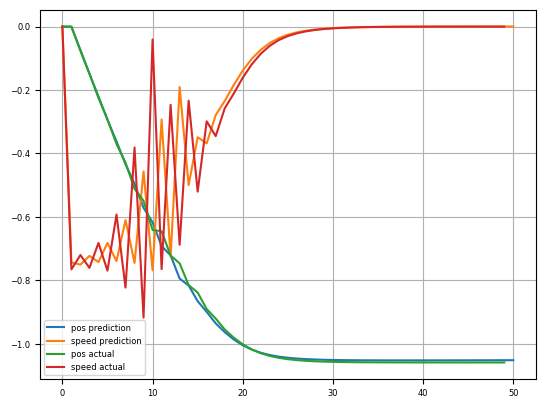

NaNs encountered when trying to perform matrix-vector multiplication
training process - model 0 - time train 2.200776 - output_scale: 0.049999997 - lengthscales: [[0.5 0.5 0.5]] - noise: [0.]
training process - model 1 - time train 8.945024 - output_scale: 0.69545275 - lengthscales: [[19.165  4.142 13.927]] - noise: [0.]
training process - previous marginal log likelihood: [-3.883 -3.798] - new marginal log likelihood: [-3.883 -4.469]
(Optimize Policy: Iter 1/12 - Loss: -31.463 )
(Optimize Policy: Iter 2/12 - Loss: -32.186 )
(Optimize Policy: Iter 3/12 - Loss: -32.185 )
(Optimize Policy: Iter 4/12 - Loss: -31.436 )
(Optimize Policy: Iter 5/12 - Loss: -31.426 )
(Optimize Policy: Iter 6/12 - Loss: -31.475 )
(Optimize Policy: Iter 7/12 - Loss: -31.830 )
(Optimize Policy: Iter 8/12 - Loss: -32.152 )
(Optimize Policy: Iter 9/12 - Loss: -32.225 )
(Optimize Policy: Iter 10/12 - Loss: -32.255 )
(Optimize Policy: Iter 11/12 - Loss: -32.298 )
(Optimize Policy: Iter 12/12 - Loss: -32.314 )


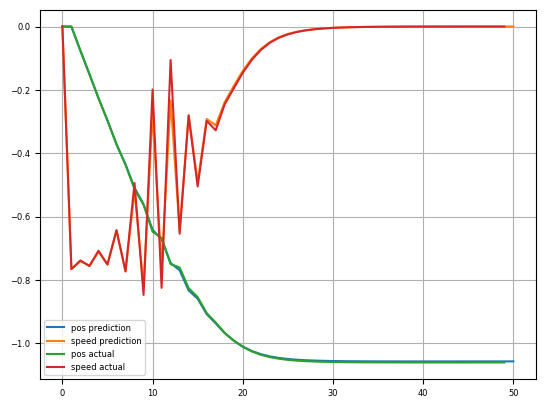

training process - model 0 - time train 11.215301 - output_scale: 0.8087705 - lengthscales: [[ 3.208 19.761  9.47 ]] - noise: [0.]
training process - model 1 - time train 33.413218 - output_scale: 0.049999997 - lengthscales: [[0.5 0.5 0.5]] - noise: [0.]
training process - previous marginal log likelihood: [-3.831 -3.719] - new marginal log likelihood: [-4.162 -3.719]
(Optimize Policy: Iter 1/12 - Loss: -32.372 )
(Optimize Policy: Iter 2/12 - Loss: -32.372 )
(Optimize Policy: Iter 3/12 - Loss: -32.327 )
(Optimize Policy: Iter 4/12 - Loss: -32.311 )
(Optimize Policy: Iter 5/12 - Loss: -32.065 )
(Optimize Policy: Iter 6/12 - Loss: -31.972 )
(Optimize Policy: Iter 7/12 - Loss: -31.983 )
(Optimize Policy: Iter 8/12 - Loss: -32.299 )
(Optimize Policy: Iter 9/12 - Loss: -32.284 )
(Optimize Policy: Iter 10/12 - Loss: -31.951 )
(Optimize Policy: Iter 11/12 - Loss: -32.119 )
(Optimize Policy: Iter 12/12 - Loss: -32.161 )


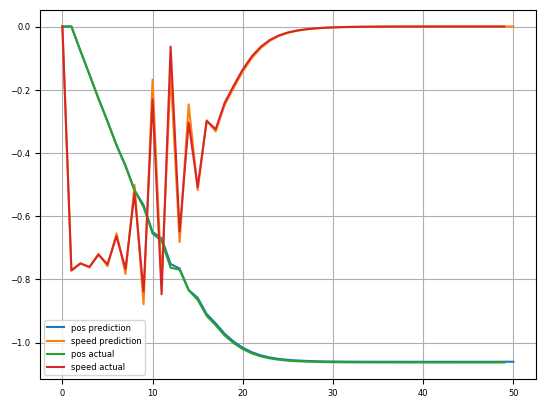

training process - model 0 - time train 6.610022 - output_scale: 0.6262335 - lengthscales: [[23.987 23.081 14.743]] - noise: [0.]
training process - model 1 - time train 14.272283 - output_scale: 0.7493388 - lengthscales: [[2.719 1.506 3.475]] - noise: [0.]
training process - previous marginal log likelihood: [-3.765 -3.657] - new marginal log likelihood: [-3.781 -3.745]
(Optimize Policy: Iter 1/12 - Loss: -32.447 )
(Optimize Policy: Iter 2/12 - Loss: -32.451 )
(Optimize Policy: Iter 3/12 - Loss: -32.454 )
(Optimize Policy: Iter 4/12 - Loss: -32.459 )
(Optimize Policy: Iter 5/12 - Loss: -32.464 )
(Optimize Policy: Iter 6/12 - Loss: -32.472 )
(Optimize Policy: Iter 7/12 - Loss: -32.460 )
(Optimize Policy: Iter 8/12 - Loss: -32.435 )
(Optimize Policy: Iter 9/12 - Loss: -32.398 )
(Optimize Policy: Iter 10/12 - Loss: -32.404 )
(Optimize Policy: Iter 11/12 - Loss: -32.329 )
(Optimize Policy: Iter 12/12 - Loss: -31.958 )


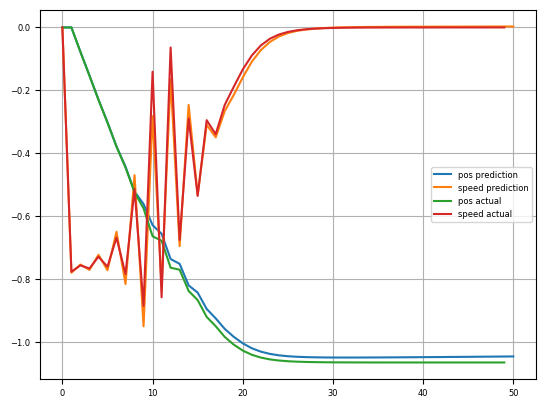

training process - model 0 - time train 3.177311 - output_scale: 0.049999997 - lengthscales: [[0.5 0.5 0.5]] - noise: [0.]
training process - model 1 - time train 9.814498 - output_scale: 0.77989155 - lengthscales: [[23.968 16.051 10.126]] - noise: [0.]
training process - previous marginal log likelihood: [-3.772 -3.616] - new marginal log likelihood: [-3.772 -3.643]
(Optimize Policy: Iter 1/12 - Loss: -32.499 )
(Optimize Policy: Iter 2/12 - Loss: -32.474 )
(Optimize Policy: Iter 3/12 - Loss: -32.476 )
(Optimize Policy: Iter 4/12 - Loss: -32.445 )
(Optimize Policy: Iter 5/12 - Loss: -32.459 )
(Optimize Policy: Iter 6/12 - Loss: -32.490 )
(Optimize Policy: Iter 7/12 - Loss: -32.520 )
(Optimize Policy: Iter 8/12 - Loss: -32.489 )
(Optimize Policy: Iter 9/12 - Loss: -32.484 )
(Optimize Policy: Iter 10/12 - Loss: -32.502 )
(Optimize Policy: Iter 11/12 - Loss: -32.531 )
(Optimize Policy: Iter 12/12 - Loss: -32.518 )


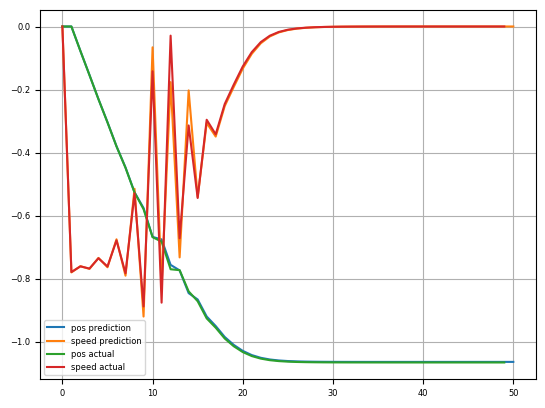

training process - model 0 - time train 12.107325 - output_scale: 0.561355 - lengthscales: [[20.942  9.439  1.65 ]] - noise: [0.]
training process - model 1 - time train 25.461675 - output_scale: 0.62615895 - lengthscales: [[4.063 1.05  2.174]] - noise: [0.]
training process - previous marginal log likelihood: [-3.722 -3.686] - new marginal log likelihood: [-4.18 -3.75]
(Optimize Policy: Iter 1/12 - Loss: -32.546 )
(Optimize Policy: Iter 2/12 - Loss: -32.537 )
(Optimize Policy: Iter 3/12 - Loss: -32.528 )
(Optimize Policy: Iter 4/12 - Loss: -32.519 )
(Optimize Policy: Iter 5/12 - Loss: -32.531 )
(Optimize Policy: Iter 6/12 - Loss: -32.546 )
(Optimize Policy: Iter 7/12 - Loss: -32.569 )
(Optimize Policy: Iter 8/12 - Loss: -32.568 )
(Optimize Policy: Iter 9/12 - Loss: -32.564 )
(Optimize Policy: Iter 10/12 - Loss: -32.429 )
(Optimize Policy: Iter 11/12 - Loss: -32.572 )
(Optimize Policy: Iter 12/12 - Loss: -32.572 )


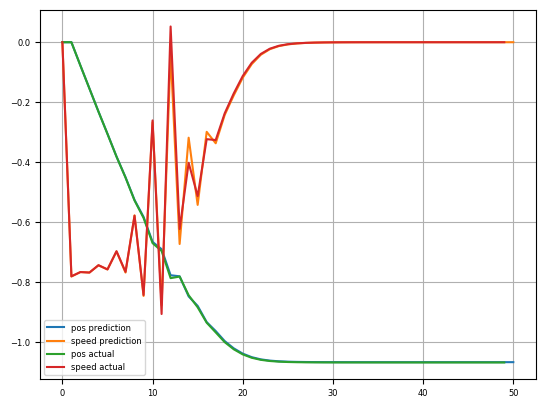

training process - model 0 - time train 7.643604 - output_scale: 0.768463 - lengthscales: [[12.401  7.648 20.117]] - noise: [0.]
training process - model 1 - time train 20.140375 - output_scale: 0.049999997 - lengthscales: [[0.5 0.5 0.5]] - noise: [0.]
training process - previous marginal log likelihood: [-3.711 -3.63 ] - new marginal log likelihood: [-3.892 -3.63 ]
(Optimize Policy: Iter 1/12 - Loss: -32.592 )
(Optimize Policy: Iter 2/12 - Loss: -32.567 )
(Optimize Policy: Iter 3/12 - Loss: -32.607 )
(Optimize Policy: Iter 4/12 - Loss: -32.574 )
(Optimize Policy: Iter 5/12 - Loss: -32.606 )
(Optimize Policy: Iter 6/12 - Loss: -32.608 )
(Optimize Policy: Iter 7/12 - Loss: -32.610 )
(Optimize Policy: Iter 8/12 - Loss: -32.618 )
(Optimize Policy: Iter 9/12 - Loss: -32.589 )
(Optimize Policy: Iter 10/12 - Loss: -32.639 )
(Optimize Policy: Iter 11/12 - Loss: -32.649 )
(Optimize Policy: Iter 12/12 - Loss: -32.663 )


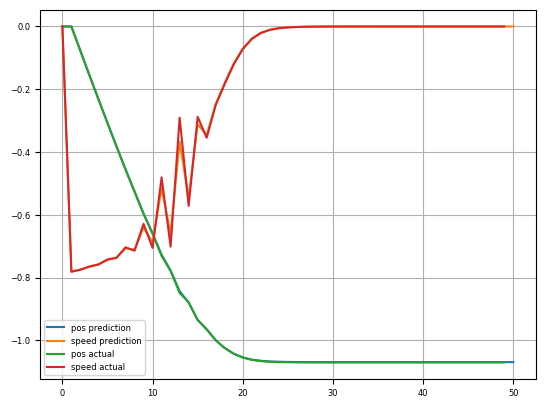

NaNs encountered when trying to perform matrix-vector multiplication
training process - model 0 - time train 6.824880 - output_scale: 0.20120196 - lengthscales: [[10.328  2.313  4.967]] - noise: [0.]
NaNs encountered when trying to perform matrix-vector multiplication
training process - model 1 - time train 9.066732 - output_scale: 0.049999997 - lengthscales: [[0.5 0.5 0.5]] - noise: [0.]
training process - previous marginal log likelihood: [-3.686 -3.613] - new marginal log likelihood: [-4.305 -3.613]
(Optimize Policy: Iter 1/12 - Loss: -32.691 )
(Optimize Policy: Iter 2/12 - Loss: -32.666 )
(Optimize Policy: Iter 3/12 - Loss: -32.653 )
(Optimize Policy: Iter 4/12 - Loss: -32.651 )
(Optimize Policy: Iter 5/12 - Loss: -32.645 )
(Optimize Policy: Iter 6/12 - Loss: -32.601 )
(Optimize Policy: Iter 7/12 - Loss: -32.607 )
(Optimize Policy: Iter 8/12 - Loss: -32.228 )
(Optimize Policy: Iter 9/12 - Loss: -31.893 )
(Optimize Policy: Iter 10/12 - Loss: -31.833 )
(Optimize Policy: Iter 11/12 - 

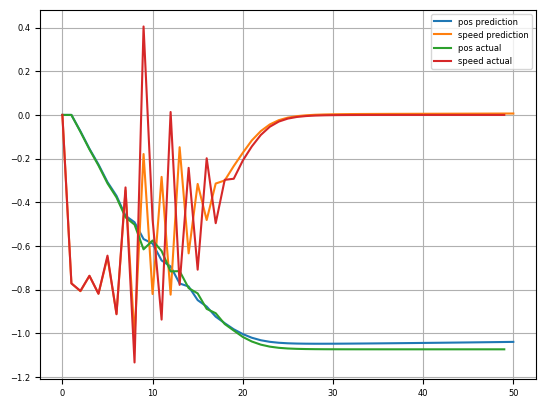

training process - model 0 - time train 77.298322 - output_scale: 0.6982152 - lengthscales: [[23.959  0.156 11.207]] - noise: [0.]
training process - model 1 - time train 87.827942 - output_scale: 0.7476808 - lengthscales: [[23.113 13.447 19.968]] - noise: [0.]
training process - previous marginal log likelihood: [-3.596 -3.5  ] - new marginal log likelihood: [-4.009 -4.24 ]
(Optimize Policy: Iter 1/12 - Loss: -32.080 )
(Optimize Policy: Iter 2/12 - Loss: -32.240 )
(Optimize Policy: Iter 3/12 - Loss: -31.871 )
(Optimize Policy: Iter 4/12 - Loss: -31.960 )
(Optimize Policy: Iter 5/12 - Loss: -31.973 )
(Optimize Policy: Iter 6/12 - Loss: -31.948 )
(Optimize Policy: Iter 7/12 - Loss: -31.843 )
(Optimize Policy: Iter 8/12 - Loss: -32.028 )
(Optimize Policy: Iter 9/12 - Loss: -31.812 )
(Optimize Policy: Iter 10/12 - Loss: -31.909 )
(Optimize Policy: Iter 11/12 - Loss: -31.940 )
(Optimize Policy: Iter 12/12 - Loss: -31.919 )


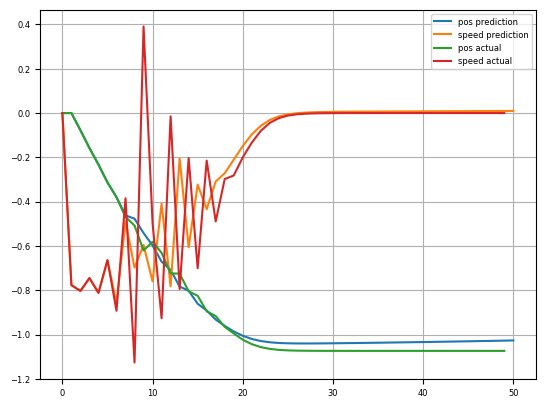

training process - model 0 - time train 9.466562 - output_scale: 0.8717731 - lengthscales: [[16.124  3.207 24.108]] - noise: [0.]
training process - model 1 - time train 14.421056 - output_scale: 0.8694577 - lengthscales: [[7.13  7.254 4.871]] - noise: [0.]
training process - previous marginal log likelihood: [-3.555 -3.512] - new marginal log likelihood: [-3.935 -3.968]
(Optimize Policy: Iter 1/12 - Loss: -32.085 )
(Optimize Policy: Iter 2/12 - Loss: -32.567 )
(Optimize Policy: Iter 3/12 - Loss: -32.204 )
(Optimize Policy: Iter 4/12 - Loss: -32.422 )
(Optimize Policy: Iter 5/12 - Loss: -31.792 )
(Optimize Policy: Iter 6/12 - Loss: -31.856 )
(Optimize Policy: Iter 7/12 - Loss: -31.532 )
(Optimize Policy: Iter 8/12 - Loss: -32.046 )
(Optimize Policy: Iter 9/12 - Loss: -31.765 )
(Optimize Policy: Iter 10/12 - Loss: -31.774 )
(Optimize Policy: Iter 11/12 - Loss: -31.990 )
(Optimize Policy: Iter 12/12 - Loss: -31.783 )


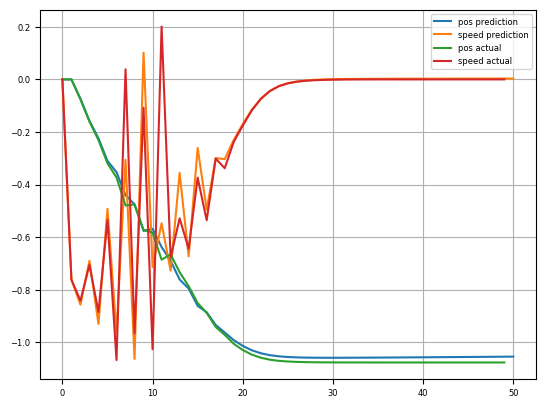

training process - model 0 - time train 12.848555 - output_scale: 0.046211198 - lengthscales: [[15.961  2.172  2.141]] - noise: [0.]
training process - model 1 - time train 24.731738 - output_scale: 0.049999997 - lengthscales: [[0.5 0.5 0.5]] - noise: [0.]
training process - previous marginal log likelihood: [-3.529 -3.433] - new marginal log likelihood: [-4.477 -3.433]
(Optimize Policy: Iter 1/12 - Loss: -32.438 )
(Optimize Policy: Iter 2/12 - Loss: -32.214 )
(Optimize Policy: Iter 3/12 - Loss: -32.155 )
(Optimize Policy: Iter 4/12 - Loss: -32.288 )
(Optimize Policy: Iter 5/12 - Loss: -32.481 )
(Optimize Policy: Iter 6/12 - Loss: -32.074 )
(Optimize Policy: Iter 7/12 - Loss: -32.261 )
(Optimize Policy: Iter 8/12 - Loss: -32.066 )
(Optimize Policy: Iter 9/12 - Loss: -32.315 )
(Optimize Policy: Iter 10/12 - Loss: -32.258 )
(Optimize Policy: Iter 11/12 - Loss: -32.277 )
(Optimize Policy: Iter 12/12 - Loss: -31.983 )


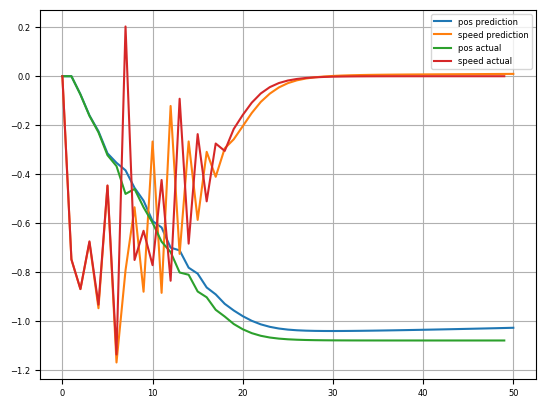

training process - model 0 - time train 10.086065 - output_scale: 0.29408488 - lengthscales: [[23.02   4.449 14.611]] - noise: [0.]
training process - model 1 - time train 33.749407 - output_scale: 0.049999997 - lengthscales: [[0.5 0.5 0.5]] - noise: [0.]
training process - previous marginal log likelihood: [-3.486 -3.377] - new marginal log likelihood: [-3.869 -3.377]
(Optimize Policy: Iter 1/12 - Loss: -32.585 )
(Optimize Policy: Iter 2/12 - Loss: -32.626 )
(Optimize Policy: Iter 3/12 - Loss: -32.578 )
(Optimize Policy: Iter 4/12 - Loss: -32.560 )
(Optimize Policy: Iter 5/12 - Loss: -32.552 )
(Optimize Policy: Iter 6/12 - Loss: -32.552 )
(Optimize Policy: Iter 7/12 - Loss: -32.551 )
(Optimize Policy: Iter 8/12 - Loss: -32.551 )
(Optimize Policy: Iter 9/12 - Loss: -32.551 )
(Optimize Policy: Iter 10/12 - Loss: -32.551 )
(Optimize Policy: Iter 11/12 - Loss: -32.550 )
(Optimize Policy: Iter 12/12 - Loss: -32.552 )


In [9]:
import matplotlib.pyplot as plt


num_episodes = 15
# eps = ExponentialSchedule(1.5, 1e-4, num_episodes)

exp = ExponentialSchedule(-1, 0, num_episodes)
lr = ExponentialSchedule(5e-2, 1e-2, num_episodes)
# lr = ExponentialSchedule(1e-2, 1e-3, num_episodes)
pilco.optim_lr = 5e-3

for _ in range(num_episodes):
    m_init = torch.from_numpy(pilco.m_init).cuda()
    S_init = torch.from_numpy(pilco.S_init).cuda()
    states_mu_pred,states_var_pred,cost = pilco.prediction(m_init,S_init)
    pilco.best_loss = torch.tensor([-cost]).cuda()
    pos_pred = states_mu_pred[:,0].detach().numpy()
    speed_pred = states_mu_pred[:,1].detach().numpy()
    
    X,Y = env_rollout(env,pilco.controller,horizon=50)
    pos_env = np.array(X)[:,0]
    speed_env = np.array(X)[:,1]
    plt.plot(pos_pred,label='pos prediction')
    plt.plot(speed_pred,label='speed prediction')
    plt.plot(pos_env,label='pos actual')
    plt.plot(speed_env,label='speed actual')
    plt.grid()
    plt.legend()
    plt.show()

    pilco.add(X,Y)
    pilco.train()
    # pilco.eps = eps.value(_) 
    pilco.optim_lr = lr.value(_)
    pilco.explore = exp.value(_)
    pilco.optimize_policy()

C:\Users\RushiS\AppData\Local\Temp\ipykernel_14808\638831587.py:17: RuntimeWarning: invalid value encountered in log
  self.b = (np.log(self.value_to)-(np.log(self.a)))/(self.num_steps-1)
C:\Users\RushiS\PILCO-gpytorch\pilco\models\mgpr.py:438: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m = torch.tensor(m).float().cuda()


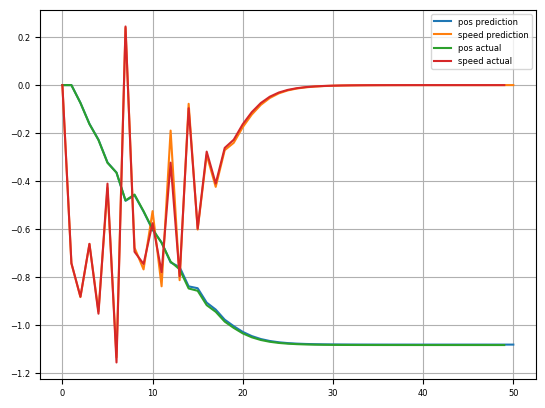

training process - model 0 - time train 15.540457 - output_scale: 0.7390112 - lengthscales: [[21.07  24.771 16.653]] - noise: [0.]
training process - model 1 - time train 34.577958 - output_scale: 0.78134704 - lengthscales: [[19.062  0.514 14.349]] - noise: [0.]
training process - previous marginal log likelihood: [-3.419 -3.34 ] - new marginal log likelihood: [-4.155 -4.159]
(Optimize Policy: Iter 1/12 - Loss: -32.604 )
(Optimize Policy: Iter 2/12 - Loss: -32.631 )
(Optimize Policy: Iter 3/12 - Loss: -32.582 )
(Optimize Policy: Iter 4/12 - Loss: -32.610 )
(Optimize Policy: Iter 5/12 - Loss: -32.279 )
(Optimize Policy: Iter 6/12 - Loss: -32.316 )
(Optimize Policy: Iter 7/12 - Loss: -32.670 )
(Optimize Policy: Iter 8/12 - Loss: -32.568 )
(Optimize Policy: Iter 9/12 - Loss: -31.980 )
(Optimize Policy: Iter 10/12 - Loss: -32.188 )
(Optimize Policy: Iter 11/12 - Loss: -31.979 )
(Optimize Policy: Iter 12/12 - Loss: -31.971 )


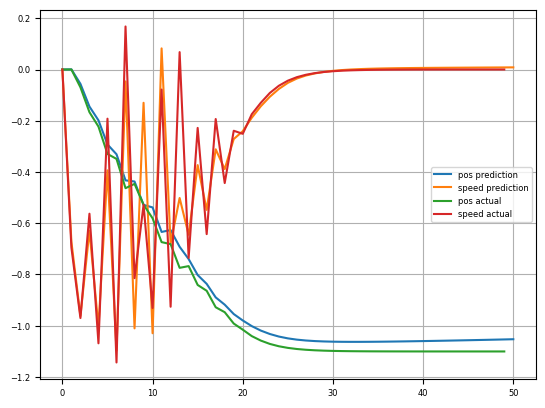

training process - model 0 - time train 15.326437 - output_scale: 0.053823147 - lengthscales: [[20.401 13.647 14.356]] - noise: [0.]
training process - model 1 - time train 19.656397 - output_scale: 0.16675626 - lengthscales: [[ 2.027  1.326 22.624]] - noise: [0.]
training process - previous marginal log likelihood: [-3.414 -3.311] - new marginal log likelihood: [-4.047 -3.718]
(Optimize Policy: Iter 1/12 - Loss: -32.618 )
(Optimize Policy: Iter 2/12 - Loss: -32.607 )
(Optimize Policy: Iter 3/12 - Loss: -32.530 )
(Optimize Policy: Iter 4/12 - Loss: -32.332 )
(Optimize Policy: Iter 5/12 - Loss: -32.400 )
(Optimize Policy: Iter 6/12 - Loss: -32.545 )
(Optimize Policy: Iter 7/12 - Loss: -32.497 )
(Optimize Policy: Iter 8/12 - Loss: -32.593 )
(Optimize Policy: Iter 9/12 - Loss: -32.385 )
(Optimize Policy: Iter 10/12 - Loss: -32.311 )
(Optimize Policy: Iter 11/12 - Loss: -32.050 )
(Optimize Policy: Iter 12/12 - Loss: -31.939 )


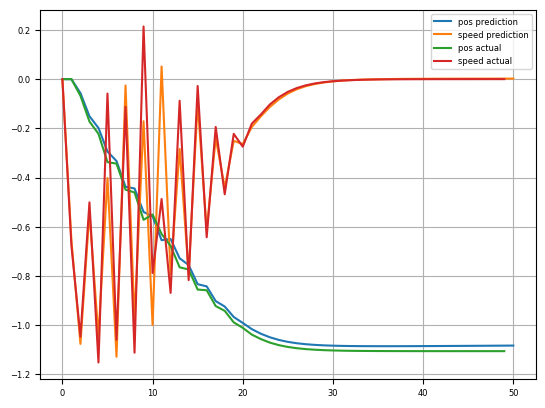

training process - model 0 - time train 11.201253 - output_scale: 0.7239299 - lengthscales: [[ 2.032 13.95  19.361]] - noise: [0.]
training process - model 1 - time train 22.754145 - output_scale: 0.37253484 - lengthscales: [[ 8.789  7.502 16.837]] - noise: [0.]
training process - previous marginal log likelihood: [-3.423 -3.278] - new marginal log likelihood: [-4.098 -3.787]
(Optimize Policy: Iter 1/12 - Loss: -32.658 )
(Optimize Policy: Iter 2/12 - Loss: -32.532 )
(Optimize Policy: Iter 3/12 - Loss: -32.223 )
(Optimize Policy: Iter 4/12 - Loss: -32.231 )
(Optimize Policy: Iter 5/12 - Loss: -32.233 )
(Optimize Policy: Iter 6/12 - Loss: -32.269 )
(Optimize Policy: Iter 7/12 - Loss: -32.349 )
(Optimize Policy: Iter 8/12 - Loss: -32.385 )
(Optimize Policy: Iter 9/12 - Loss: -32.380 )
(Optimize Policy: Iter 10/12 - Loss: -32.375 )
(Optimize Policy: Iter 11/12 - Loss: -32.366 )
(Optimize Policy: Iter 12/12 - Loss: -32.460 )


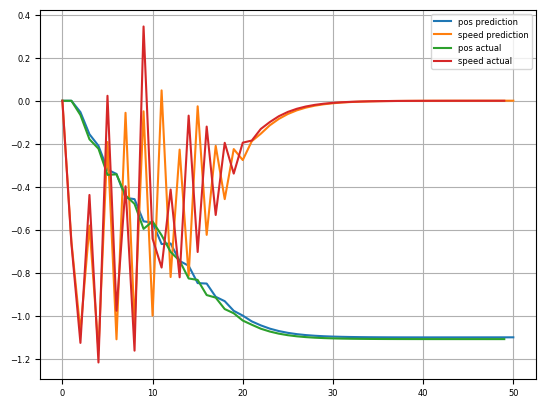

training process - model 0 - time train 34.687779 - output_scale: 0.13556916 - lengthscales: [[22.561 23.879  1.934]] - noise: [0.]
training process - model 1 - time train 50.030914 - output_scale: 0.8072321 - lengthscales: [[15.059 12.666 17.534]] - noise: [0.]
training process - previous marginal log likelihood: [-3.347 -3.279] - new marginal log likelihood: [-4.655 -4.072]
(Optimize Policy: Iter 1/12 - Loss: -32.741 )
(Optimize Policy: Iter 2/12 - Loss: -32.698 )
(Optimize Policy: Iter 3/12 - Loss: -32.552 )
(Optimize Policy: Iter 4/12 - Loss: -32.442 )
(Optimize Policy: Iter 5/12 - Loss: -32.561 )
(Optimize Policy: Iter 6/12 - Loss: -32.216 )
(Optimize Policy: Iter 7/12 - Loss: -32.332 )
(Optimize Policy: Iter 8/12 - Loss: -32.435 )
(Optimize Policy: Iter 9/12 - Loss: -32.242 )
(Optimize Policy: Iter 10/12 - Loss: -32.194 )
(Optimize Policy: Iter 11/12 - Loss: -32.302 )
(Optimize Policy: Iter 12/12 - Loss: -32.409 )


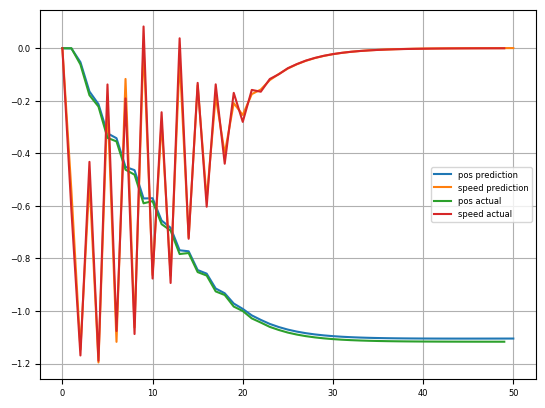

training process - model 0 - time train 46.697183 - output_scale: 0.09481505 - lengthscales: [[16.764  3.831 19.969]] - noise: [0.]
training process - model 1 - time train 90.631228 - output_scale: 0.8089113 - lengthscales: [[10.019  9.104 14.974]] - noise: [0.]
training process - previous marginal log likelihood: [-3.785 -3.709] - new marginal log likelihood: [-5.95  -5.881]
(Optimize Policy: Iter 1/12 - Loss: -32.731 )
(Optimize Policy: Iter 2/12 - Loss: -32.714 )
(Optimize Policy: Iter 3/12 - Loss: -32.705 )
(Optimize Policy: Iter 4/12 - Loss: -32.702 )
(Optimize Policy: Iter 5/12 - Loss: -32.702 )
(Optimize Policy: Iter 6/12 - Loss: -32.702 )
(Optimize Policy: Iter 7/12 - Loss: -32.707 )
(Optimize Policy: Iter 8/12 - Loss: -32.731 )
(Optimize Policy: Iter 9/12 - Loss: -32.732 )
(Optimize Policy: Iter 10/12 - Loss: -32.710 )
(Optimize Policy: Iter 11/12 - Loss: -32.652 )
(Optimize Policy: Iter 12/12 - Loss: -32.621 )


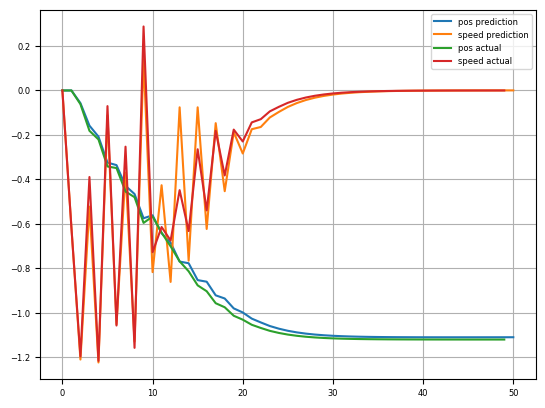

training process - model 0 - time train 26.823768 - output_scale: 0.6664435 - lengthscales: [[ 2.769  6.44  14.021]] - noise: [0.]
training process - model 1 - time train 75.122956 - output_scale: 0.8077816 - lengthscales: [[15.657  4.322 16.288]] - noise: [0.]
training process - previous marginal log likelihood: [-3.742 -3.705] - new marginal log likelihood: [-5.94  -5.918]
(Optimize Policy: Iter 1/12 - Loss: -32.820 )
(Optimize Policy: Iter 2/12 - Loss: -32.819 )
(Optimize Policy: Iter 3/12 - Loss: -32.672 )
(Optimize Policy: Iter 4/12 - Loss: -32.728 )
(Optimize Policy: Iter 5/12 - Loss: -32.691 )
(Optimize Policy: Iter 6/12 - Loss: -32.689 )
(Optimize Policy: Iter 7/12 - Loss: -32.701 )
(Optimize Policy: Iter 8/12 - Loss: -32.681 )
(Optimize Policy: Iter 9/12 - Loss: -32.721 )
(Optimize Policy: Iter 10/12 - Loss: -32.652 )
(Optimize Policy: Iter 11/12 - Loss: -32.812 )
(Optimize Policy: Iter 12/12 - Loss: -32.827 )


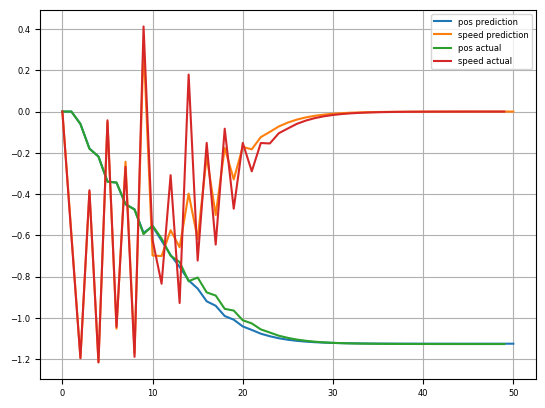

training process - model 0 - time train 40.037696 - output_scale: 0.404858 - lengthscales: [[18.185 22.451 21.176]] - noise: [0.]
training process - model 1 - time train 76.858105 - output_scale: 0.92929876 - lengthscales: [[11.993 10.223 19.555]] - noise: [0.]
training process - previous marginal log likelihood: [-3.752 -3.712] - new marginal log likelihood: [-5.958 -5.903]
(Optimize Policy: Iter 1/12 - Loss: -32.790 )
(Optimize Policy: Iter 2/12 - Loss: -32.799 )
(Optimize Policy: Iter 3/12 - Loss: -32.821 )
(Optimize Policy: Iter 4/12 - Loss: -32.816 )
(Optimize Policy: Iter 5/12 - Loss: -32.867 )
(Optimize Policy: Iter 6/12 - Loss: -32.805 )
(Optimize Policy: Iter 7/12 - Loss: -32.765 )
(Optimize Policy: Iter 8/12 - Loss: -32.759 )
(Optimize Policy: Iter 9/12 - Loss: -32.869 )
(Optimize Policy: Iter 10/12 - Loss: -32.727 )
(Optimize Policy: Iter 11/12 - Loss: -32.715 )
(Optimize Policy: Iter 12/12 - Loss: -32.806 )


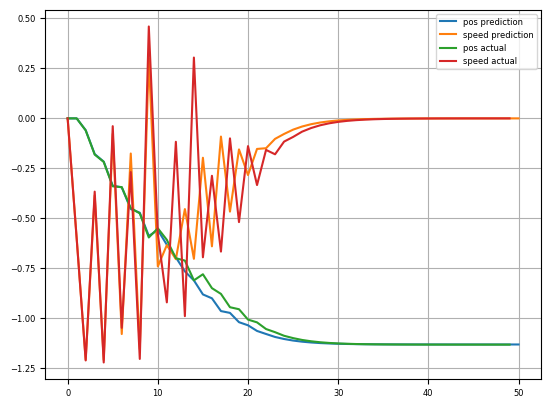

training process - model 0 - time train 30.765471 - output_scale: 0.5921206 - lengthscales: [[23.177  8.543 12.096]] - noise: [0.]
training process - model 1 - time train 79.342973 - output_scale: 0.6559199 - lengthscales: [[18.967  3.019 15.538]] - noise: [0.]
training process - previous marginal log likelihood: [-3.698 -3.638] - new marginal log likelihood: [-5.952 -5.894]
(Optimize Policy: Iter 1/12 - Loss: -32.696 )
(Optimize Policy: Iter 2/12 - Loss: -32.709 )
(Optimize Policy: Iter 3/12 - Loss: -32.706 )
(Optimize Policy: Iter 4/12 - Loss: -32.731 )
(Optimize Policy: Iter 5/12 - Loss: -32.775 )
(Optimize Policy: Iter 6/12 - Loss: -32.780 )
(Optimize Policy: Iter 7/12 - Loss: -32.809 )
(Optimize Policy: Iter 8/12 - Loss: -32.720 )
(Optimize Policy: Iter 9/12 - Loss: -32.717 )
(Optimize Policy: Iter 10/12 - Loss: -32.744 )
(Optimize Policy: Iter 11/12 - Loss: -32.744 )
(Optimize Policy: Iter 12/12 - Loss: -32.638 )


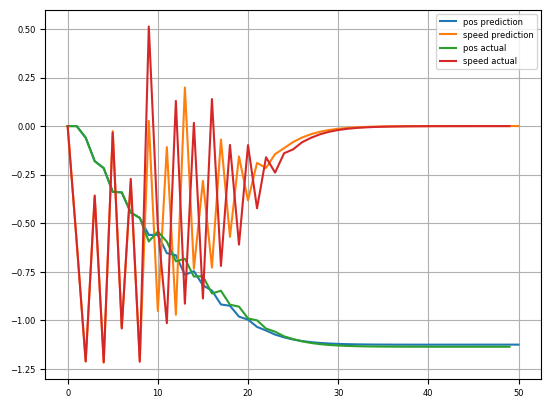

training process - model 0 - time train 48.675381 - output_scale: 0.49574482 - lengthscales: [[12.596  9.728  4.752]] - noise: [0.]
training process - model 1 - time train 87.270486 - output_scale: 0.92747456 - lengthscales: [[7.481 2.029 7.38 ]] - noise: [0.]
training process - previous marginal log likelihood: [-3.689 -3.598] - new marginal log likelihood: [-5.881 -5.856]
(Optimize Policy: Iter 1/12 - Loss: -32.782 )
(Optimize Policy: Iter 2/12 - Loss: -32.752 )
(Optimize Policy: Iter 3/12 - Loss: -32.761 )
(Optimize Policy: Iter 4/12 - Loss: -32.792 )
(Optimize Policy: Iter 5/12 - Loss: -32.790 )
(Optimize Policy: Iter 6/12 - Loss: -32.796 )
(Optimize Policy: Iter 7/12 - Loss: -32.798 )
(Optimize Policy: Iter 8/12 - Loss: -32.793 )
(Optimize Policy: Iter 9/12 - Loss: -32.803 )
(Optimize Policy: Iter 10/12 - Loss: -32.778 )
(Optimize Policy: Iter 11/12 - Loss: -32.766 )
(Optimize Policy: Iter 12/12 - Loss: -32.728 )


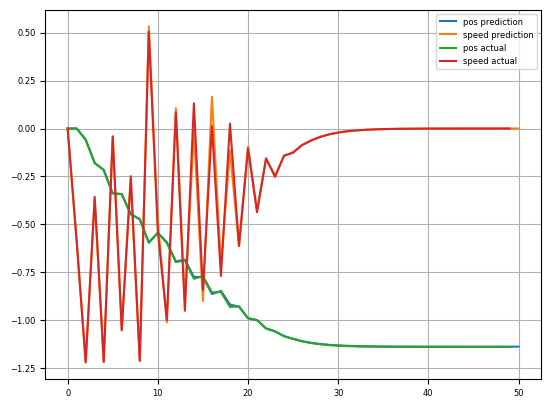

training process - model 0 - time train 49.696831 - output_scale: 0.20350619 - lengthscales: [[18.061  2.814  8.791]] - noise: [0.]
training process - model 1 - time train 90.227013 - output_scale: 0.94850856 - lengthscales: [[21.278  9.741 23.486]] - noise: [0.]
training process - previous marginal log likelihood: [-3.686 -3.584] - new marginal log likelihood: [-5.931 -5.912]
(Optimize Policy: Iter 1/12 - Loss: -32.816 )
(Optimize Policy: Iter 2/12 - Loss: -32.814 )
(Optimize Policy: Iter 3/12 - Loss: -32.812 )
(Optimize Policy: Iter 4/12 - Loss: -32.817 )
(Optimize Policy: Iter 5/12 - Loss: -32.812 )
(Optimize Policy: Iter 6/12 - Loss: -32.806 )
(Optimize Policy: Iter 7/12 - Loss: -32.787 )
(Optimize Policy: Iter 8/12 - Loss: -32.773 )
(Optimize Policy: Iter 9/12 - Loss: -32.805 )
(Optimize Policy: Iter 10/12 - Loss: -32.815 )
(Optimize Policy: Iter 11/12 - Loss: -32.814 )
(Optimize Policy: Iter 12/12 - Loss: -32.813 )


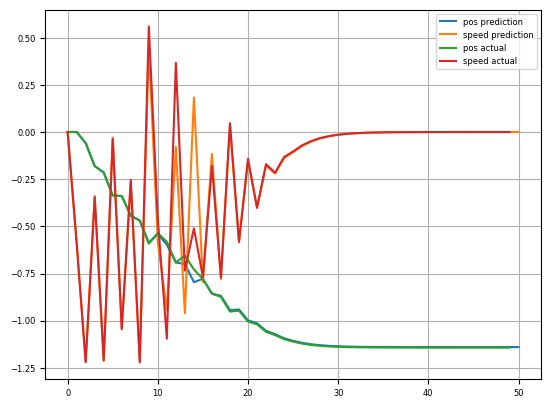

training process - model 0 - time train 46.069626 - output_scale: 0.66075253 - lengthscales: [[ 2.942 20.023 16.205]] - noise: [0.]
training process - model 1 - time train 83.351163 - output_scale: 0.8427448 - lengthscales: [[15.455  0.255 14.077]] - noise: [0.]
training process - previous marginal log likelihood: [-3.588 -3.54 ] - new marginal log likelihood: [-5.94  -5.596]
(Optimize Policy: Iter 1/12 - Loss: -32.818 )
(Optimize Policy: Iter 2/12 - Loss: -32.818 )
(Optimize Policy: Iter 3/12 - Loss: -32.827 )
(Optimize Policy: Iter 4/12 - Loss: -32.827 )
(Optimize Policy: Iter 5/12 - Loss: -32.832 )
(Optimize Policy: Iter 6/12 - Loss: -32.833 )
(Optimize Policy: Iter 7/12 - Loss: -32.837 )
(Optimize Policy: Iter 8/12 - Loss: -32.842 )
(Optimize Policy: Iter 9/12 - Loss: -32.846 )
(Optimize Policy: Iter 10/12 - Loss: -32.847 )
(Optimize Policy: Iter 11/12 - Loss: -32.849 )
(Optimize Policy: Iter 12/12 - Loss: -32.844 )


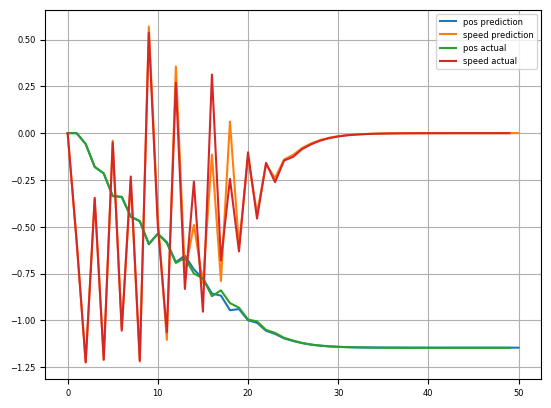

training process - model 0 - time train 61.025057 - output_scale: 0.8691863 - lengthscales: [[21.631  4.097 12.005]] - noise: [0.]


c:\Users\RushiS\anaconda3\envs\gp_rl_env\lib\site-packages\linear_operator\operators\added_diag_linear_operator.py:128: NumericalWarning: NaNs encountered in preconditioner computation. Attempting to continue without preconditioning.
  warnings.warn(


NaNs encountered when trying to perform matrix-vector multiplication
training process - model 1 - time train 92.872989 - output_scale: 0.9166413 - lengthscales: [[21.256  4.257 19.619]] - noise: [0.]
training process - previous marginal log likelihood: [-3.586 -3.534] - new marginal log likelihood: [-5.936 -5.929]
(Optimize Policy: Iter 1/12 - Loss: -32.852 )
(Optimize Policy: Iter 2/12 - Loss: -32.861 )
(Optimize Policy: Iter 3/12 - Loss: -32.869 )
(Optimize Policy: Iter 4/12 - Loss: -32.849 )
(Optimize Policy: Iter 5/12 - Loss: -32.841 )
(Optimize Policy: Iter 6/12 - Loss: -32.854 )
(Optimize Policy: Iter 7/12 - Loss: -32.851 )
(Optimize Policy: Iter 8/12 - Loss: -32.848 )
(Optimize Policy: Iter 9/12 - Loss: -32.870 )
(Optimize Policy: Iter 10/12 - Loss: -32.869 )
(Optimize Policy: Iter 11/12 - Loss: -32.870 )
(Optimize Policy: Iter 12/12 - Loss: -32.847 )


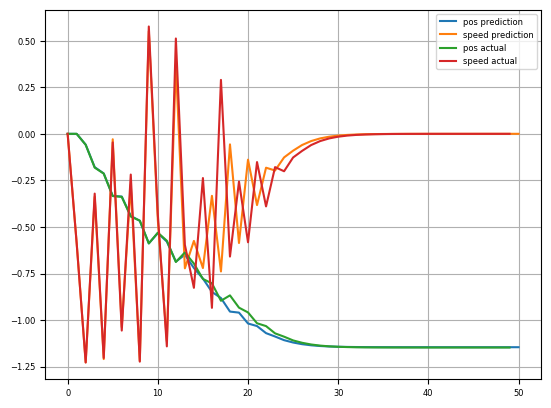

training process - model 0 - time train 62.695449 - output_scale: 0.92082435 - lengthscales: [[ 3.953 13.18  23.017]] - noise: [0.]
training process - model 1 - time train 129.144451 - output_scale: 0.9276618 - lengthscales: [[13.563  3.472 17.351]] - noise: [0.]
training process - previous marginal log likelihood: [-3.565 -3.485] - new marginal log likelihood: [-5.922 -5.935]
(Optimize Policy: Iter 1/12 - Loss: -32.802 )
(Optimize Policy: Iter 2/12 - Loss: -32.795 )
(Optimize Policy: Iter 3/12 - Loss: -32.808 )
(Optimize Policy: Iter 4/12 - Loss: -32.799 )
(Optimize Policy: Iter 5/12 - Loss: -32.816 )
(Optimize Policy: Iter 6/12 - Loss: -32.831 )
(Optimize Policy: Iter 7/12 - Loss: -32.833 )
(Optimize Policy: Iter 8/12 - Loss: -32.835 )
(Optimize Policy: Iter 9/12 - Loss: -32.835 )
(Optimize Policy: Iter 10/12 - Loss: -32.836 )
(Optimize Policy: Iter 11/12 - Loss: -32.837 )
(Optimize Policy: Iter 12/12 - Loss: -32.838 )


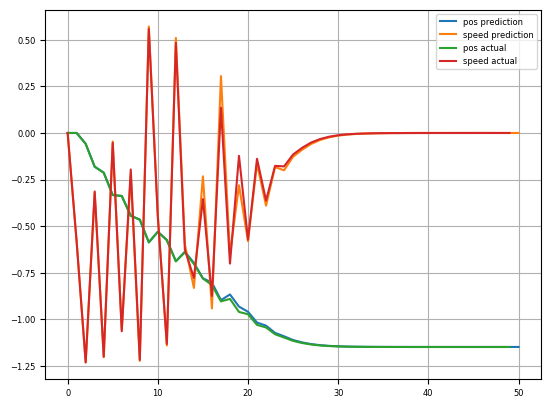

training process - model 0 - time train 56.203098 - output_scale: 0.75435793 - lengthscales: [[18.258 24.915 14.929]] - noise: [0.]
training process - model 1 - time train 118.385339 - output_scale: 0.79057264 - lengthscales: [[11.889  2.685 20.731]] - noise: [0.]
training process - previous marginal log likelihood: [-3.566 -3.508] - new marginal log likelihood: [-5.943 -5.911]
(Optimize Policy: Iter 1/12 - Loss: -32.836 )
(Optimize Policy: Iter 2/12 - Loss: -32.840 )
(Optimize Policy: Iter 3/12 - Loss: -32.837 )
(Optimize Policy: Iter 4/12 - Loss: -32.833 )
(Optimize Policy: Iter 5/12 - Loss: -32.827 )
(Optimize Policy: Iter 6/12 - Loss: -32.822 )
(Optimize Policy: Iter 7/12 - Loss: -32.821 )
(Optimize Policy: Iter 8/12 - Loss: -32.821 )
(Optimize Policy: Iter 9/12 - Loss: -32.821 )
(Optimize Policy: Iter 10/12 - Loss: -32.822 )
(Optimize Policy: Iter 11/12 - Loss: -32.822 )
(Optimize Policy: Iter 12/12 - Loss: -32.823 )


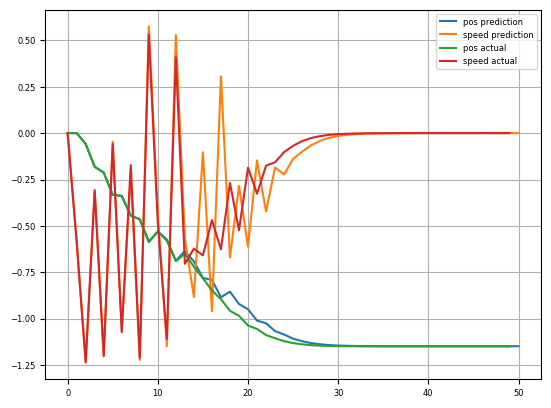

training process - model 0 - time train 36.356044 - output_scale: 0.575946 - lengthscales: [[ 0.599 13.866 23.986]] - noise: [0.]
training process - model 1 - time train 87.527182 - output_scale: 0.88521886 - lengthscales: [[20.553  0.154 23.798]] - noise: [0.]
training process - previous marginal log likelihood: [-3.575 -3.481] - new marginal log likelihood: [-5.931 -5.001]
(Optimize Policy: Iter 1/12 - Loss: -32.853 )
(Optimize Policy: Iter 2/12 - Loss: -32.864 )
(Optimize Policy: Iter 3/12 - Loss: -32.866 )
(Optimize Policy: Iter 4/12 - Loss: -32.866 )
(Optimize Policy: Iter 5/12 - Loss: -32.851 )
(Optimize Policy: Iter 6/12 - Loss: -32.866 )
(Optimize Policy: Iter 7/12 - Loss: -32.869 )
(Optimize Policy: Iter 8/12 - Loss: -32.872 )
(Optimize Policy: Iter 9/12 - Loss: -32.866 )
(Optimize Policy: Iter 10/12 - Loss: -32.849 )
(Optimize Policy: Iter 11/12 - Loss: -32.855 )
(Optimize Policy: Iter 12/12 - Loss: -32.846 )


In [10]:
num_episodes = 15
# eps = ExponentialSchedule(1.5, 1e-4, num_episodes)

exp = ExponentialSchedule(-5, -0.1, num_episodes)
lr = ExponentialSchedule(1e-1, 5e-2, num_episodes)
# lr = ExponentialSchedule(1e-2, 1e-3, num_episodes)
# pilco.optim_lr = 5e-3

for _ in range(num_episodes):
    m_init = torch.from_numpy(pilco.m_init).cuda()
    S_init = torch.from_numpy(pilco.S_init).cuda()
    states_mu_pred,states_var_pred,cost = pilco.prediction(m_init,S_init)
    pilco.best_loss = torch.tensor([-cost]).cuda()
    pos_pred = states_mu_pred[:,0].detach().numpy()
    speed_pred = states_mu_pred[:,1].detach().numpy()
    
    X,Y = env_rollout(env,pilco.controller,horizon=50)
    pos_env = np.array(X)[:,0]
    speed_env = np.array(X)[:,1]
    plt.plot(pos_pred,label='pos prediction')
    plt.plot(speed_pred,label='speed prediction')
    plt.plot(pos_env,label='pos actual')
    plt.plot(speed_env,label='speed actual')
    plt.grid()
    plt.legend()
    plt.show()

    pilco.add(X,Y)
    pilco.train()
    # pilco.eps = eps.value(_) 
    pilco.optim_lr = lr.value(_)
    pilco.explore = exp.value(_)
    pilco.optimize_policy()

In [21]:
#OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 3.40 GiB already allocated; 0 bytes free; 3.41 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
# torch.cuda.empty_cache()
# import gc
# del pilco
# gc.collect()
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

NameError: name 'pilco' is not defined

In [29]:
u_bang_bang = np.genfromtxt('./bang_bang_controller.csv', delimiter=',')
x_bang_bang = np.genfromtxt('./bang_bang_states.csv', delimiter=',')
x_bang_bang = x_bang_bang[:,:-1].T
u_bang_bang =u_bang_bang[:,None]
num_basis = len(u_bang_bang)

print(np.shape(x_bang_bang))
print(np.shape(u_bang_bang))
print(num_basis)

# np.random.randn(num_basis_functions, state_dim),
# 0.1*np.random.randn(num_basis_functions, control_dim)

x_values = x_bang_bang
y_values = u_bang_bang


controller = RbfController(2,1,num_basis,max_action = 1)

controller.create_model(x_values,y_values)

env.state = (np.array([-1,0]))
state_var = np.eye(2)*1e-6
print(controller.compute_action(env.state,state_var,squash=False))

(21, 2)
(21, 1)
21
(tensor([[0.0621, 0.0621, 0.0621, 0.0621, 0.0621, 0.0621, 0.0621, 0.0621, 0.0621,
         0.0621, 0.0621, 0.0621, 0.0621, 0.0621, 0.0621, 0.0621, 0.0621, 0.0621,
         0.0621, 0.0621, 0.0621]], device='cuda:0', grad_fn=<TBackward0>), tensor([[1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06,
         1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06,
         1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06,
         1.0133e-06, 1.0133e-06, 1.0133e-06],
        [1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06,
         1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06,
         1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06,
         1.0133e-06, 1.0133e-06, 1.0133e-06],
        [1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06,
         1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06, 1.0133e-06,
   

C:\Users\RushiS\PILCO-gpytorch\pilco\controllers.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = Parameter(torch.tensor(X).float().cuda(),requires_grad=True)
C:\Users\RushiS\PILCO-gpytorch\pilco\controllers.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = Parameter(torch.tensor(Y).float().cuda(),requires_grad=True)
C:\Users\RushiS\PILCO-gpytorch\pilco\models\mgpr.py:438: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m = torch.tensor(m).float().cuda()


In [7]:
import matplotlib.pyplot as plt
m_init = torch.from_numpy(pilco.m_init).cuda()
S_init = torch.from_numpy(pilco.S_init).cuda()
states_mu_pred,states_var_pred,reward = pilco.prediction(m_init,S_init)
print(reward)
pilco.best_loss = torch.tensor([-reward]).cuda()
pos_pred = states_mu_pred[:,0].detach().numpy()
speed_pred = states_mu_pred[:,1].detach().numpy()

X,Y = env_rollout(env,pilco.controller,horizon=50)
pos_env = np.array(X)[:,0]
speed_env = np.array(X)[:,1]
plt.plot(pos_pred,label='pos prediction')
plt.plot(speed_pred,label='speed prediction')
plt.plot(pos_env,label='pos actual')
plt.plot(speed_env,label='speed actual')
plt.grid()
plt.legend()
plt.show()

NameError: name 'pilco' is not defined

In [135]:
pilco.add(X,Y)
pilco.train()

training process - model 0 - time train 9.426349 - output_scale: 0.30307925 - lengthscales: [[ 6.961 22.899 23.83 ]] - noise: [0.]
training process - model 1 - time train 27.024731 - output_scale: 0.3899761 - lengthscales: [[13.929 23.55  14.093]] - noise: [0.]
training process - previous marginal log likelihood: [-3.564  0.865] - new marginal log likelihood: [-4.346 -2.097]


In [130]:
pilco.optim_lr = 5e-3
# pilco.best_loss = torch.tensor([0]).cuda()
pilco.optimize_policy()

(Optimize Policy: Iter 1/ - Loss: -15.286 - dLoss: 15.2857 - Best Loss - -15.286)
(Optimize Policy: Iter 2/ - Loss: -15.366 - dLoss: 0.0802 - Best Loss - -15.366)


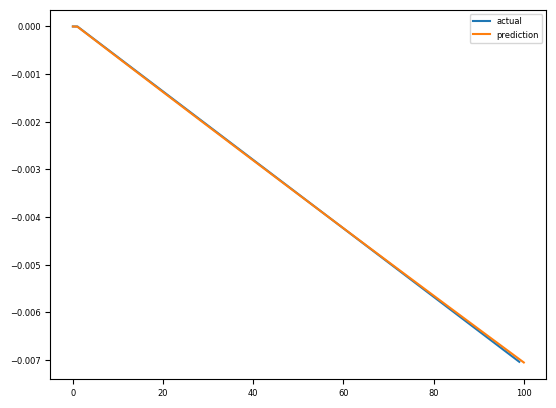

In [53]:
import matplotlib.pyplot as plt
states_mu_pred,states_var_pred,reward,X,Y = prediction(env,controller,R,transition_model,m_init,S_init)

states_env = np.array(X)[:,0]
states_pred = states_mu_pred[:,0].detach().numpy()

plt.plot(states_env,label='actual')
plt.plot(states_pred,label='prediction')
plt.legend()

In [54]:
maxiter = 12
optimizer = torch.optim.Adam([
                {'params':controller.parameters()},
                ], lr=5e-1)
m_init = m_init.cuda()
S_init = S_init.cuda()
reward = torch.zeros(1).float().cuda()
for i in range(maxiter):
            optimizer.zero_grad()
            states_mu_pred,states_var_pred,reward,X,Y = prediction(env,controller,R,transition_model,m_init,S_init)
            states_mu_pred.detach(); states_var_pred.detach()
            print(reward)
            loss = -reward
            loss.backward()
            # plot_grad_flow_v2(self.controller.parameters())
            print('(Optimize Policy: Iter %d/%d - Loss: %.3f)' % (i,maxiter,loss.item()))
            optimizer.step()

tensor([[0.0004]], device='cuda:0', grad_fn=<AddBackward0>)


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [43]:
optimizer.zero_grad()
m = torch.tensor(m_init).float().cuda()
s = torch.tensor(S_init).float().cuda()
# reward = prediction(env,controller,R,transition_model,m_init,S_init)[2]
states_mu_pred,states_var_pred,reward,X,Y = prediction(env,controller,R,transition_model,m_init,S_init)
print(X)
states_mu_pred = states_mu_pred.detach(); states_var_pred= states_var_pred.detach()
print(reward.cpu())
loss = -reward.cpu()
loss.backward(retain_graph=True)

C:\Users\RushiS\AppData\Local\Temp\ipykernel_19064\430597605.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m = torch.tensor(m_init).float().cuda()
C:\Users\RushiS\AppData\Local\Temp\ipykernel_19064\430597605.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s = torch.tensor(S_init).float().cuda()
C:\Users\RushiS\PILCO-gpytorch\pilco\models\mgpr.py:438: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m = torch.tensor(m).float().cuda()


[array([ 0.   ,  0.   , -0.007]), array([ 0.   , -0.001, -0.007]), array([-0.   , -0.001, -0.007]), array([-0.   , -0.001, -0.007]), array([-0.   , -0.001, -0.007]), array([-0.   , -0.001, -0.007]), array([-0.   , -0.001, -0.007]), array([-0.   , -0.001, -0.007]), array([-0.001, -0.001, -0.007]), array([-0.001, -0.001, -0.007]), array([-0.001, -0.001, -0.007]), array([-0.001, -0.001, -0.007]), array([-0.001, -0.001, -0.007]), array([-0.001, -0.001, -0.007]), array([-0.001, -0.001, -0.007]), array([-0.001, -0.001, -0.007]), array([-0.001, -0.001, -0.007]), array([-0.001, -0.001, -0.007]), array([-0.001, -0.001, -0.007]), array([-0.001, -0.001, -0.007]), array([-0.001, -0.001, -0.007]), array([-0.001, -0.001, -0.007]), array([-0.002, -0.001, -0.007]), array([-0.002, -0.001, -0.007]), array([-0.002, -0.001, -0.007]), array([-0.002, -0.001, -0.007]), array([-0.002, -0.001, -0.007]), array([-0.002, -0.001, -0.007]), array([-0.002, -0.001, -0.007]), array([-0.002, -0.001, -0.007]), array([-0

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [6]:

from pilco.controllers import RbfController, LinearController, squash_sin
import numpy as np
import os
import torch
import oct2py
# octave = oct2py.Oct2Py()
# dir_path = os.path.dirname(os.path.realpath("__file__")) + "/tests/Matlab Code"
# octave.addpath(dir_path)


d = 3  # Input dimension
k = 1  # Number of outputs
b = 100 # basis functions

# Training Dataset
X0 = np.random.rand(100, d)
A = np.random.rand(d, k)
Y0 = np.sin(X0).dot(A) + 1e-3*(np.random.rand(100, k) - 0.5)  #  Just something smooth
rbf = RbfController(3, 2, b)
rbf.set_XY(X0, Y0)

# Generate input
m = np.random.rand(1, d)  # But MATLAB defines it as m'
s = np.random.rand(d, d)
s = s.dot(s.T)  # Make s positive semidefinite

M, S, V = rbf.compute_action(m, s, squash=False)
# def test_rbf():
#     np.random.seed(0)
#     d = 3  # Input dimension
#     k = 1  # Number of outputs
#     b = 100 # basis functions

#     # Training Dataset
#     X0 = np.random.rand(100, d)
#     A = np.random.rand(d, k)
#     Y0 = np.sin(X0).dot(A) + 1e-3*(np.random.rand(100, k) - 0.5)  #  Just something smooth
#     rbf = RbfController(3, 2, b)
#     rbf.set_XY(X0, Y0)

#     # Generate input
#     m = np.random.rand(1, d)  # But MATLAB defines it as m'
#     s = np.random.rand(d, d)
#     s = s.dot(s.T)  # Make s positive semidefinite

#     M, S, V = rbf.compute_action(m, s, squash=False)

#     print("M\n",M)
#     print("S\n",S)
#     print("V\n",V)
#     # convert data to the struct expected by the MATLAB implementation
#     lengthscales = rbf.model.covar_module.lengthscale.cpu().detach().numpy().squeeze()
#     variance = 1*np.ones(k)  
#     noise = rbf.model.likelihood.noise.cpu().detach().numpy().squeeze()


#     hyp = np.log(np.hstack(
#         (lengthscales,
#          np.sqrt(variance[:, None]),
#          np.sqrt(noise[:, None]))
#     )).T

#     gpmodel = oct2py.io.Struct()
#     gpmodel.hyp = hyp
#     gpmodel.inputs = X0
#     gpmodel.targets = Y0

#     # Call gp0 in octave
#     M_mat, S_mat, V_mat = octave.gp2(gpmodel, m.T, s, nout=3)

#     assert M.shape == M_mat.T.shape
#     assert S.shape == S_mat.shape
#     assert V.shape == V_mat.shape
#     np.testing.assert_allclose(M, M_mat.T, rtol=1e-4)
#     np.testing.assert_allclose(S, S_mat, rtol=1e-4)
#     np.testing.assert_allclose(V, V_mat, rtol=1e-4)

# def test_linear():
#     np.random.seed(0)
#     d = 3  # Input dimension
#     k = 2  # Output dimension
#     # Generate input
#     m = np.random.rand(1, d)  # But MATLAB defines it as m'
#     s = np.random.rand(d, d)
#     s = s.dot(s.T)  # Make s positive semidefinite

#     W = np.random.rand(k, d)  # But MATLAB defines it as m'
#     b = np.random.rand(1, k)

#     linear = LinearController(d, k)
#     linear.W = torch.from_numpy(W).float().cuda()
#     linear.b = torch.from_numpy(b).float().cuda()

#     M, S, V = linear.compute_action(m, s,squash=False)

#     # convert data to the struct expected by the MATLAB implementation
#     policy = oct2py.io.Struct()
#     policy.p = oct2py.io.Struct()
#     policy.p.w = W
#     policy.p.b = b.T

#     # Call function in octave
#     M_mat, S_mat, V_mat = octave.conlin(policy, m.T, s, nout=3)

#     assert M.shape == M_mat.T.shape
#     assert S.shape == S_mat.shape
#     assert V.shape == V_mat.shape
#     np.testing.assert_allclose(M, M_mat.T, rtol=1e-4)
#     np.testing.assert_allclose(S, S_mat, rtol=1e-4)
#     np.testing.assert_allclose(V, V_mat, rtol=1e-4)

# def test_squash():
#     np.random.seed(0)
#     d = 3  # Control dimensions

#     m = np.random.rand(1, d)  # But MATLAB defines it as m'
#     s = np.random.rand(d, d)
#     s = s.dot(s.T)
#     e = 7.0

#     M, S, V = squash_sin(torch.tensor(m).float().cuda(), torch.tensor(s).float().cuda(), torch.tensor(e).float().cuda())

#     M_mat, S_mat, V_mat = octave.gSin(m.T, s, e, nout=3)
#     M_mat = np.asarray(M_mat)
#     import pdb;pdb.set_trace()

#     assert M.shape == M_mat.T.shape
#     assert S.shape == S_mat.shape
#     assert V.shape == V_mat.shape

#     np.testing.assert_allclose(M, M_mat.T, rtol=1e-4)
#     np.testing.assert_allclose(S, S_mat, rtol=1e-4)
#     np.testing.assert_allclose(V, V_mat, rtol=1e-4)


# if __name__ == '__main__':
#     test_rbf()
#     # test_linear()
#     # test_squash()


C:\Users\RushiS\PILCO-gpytorch\pilco\controllers.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = Parameter(torch.tensor(X).float().cuda(),requires_grad=True)
C:\Users\RushiS\PILCO-gpytorch\pilco\controllers.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = Parameter(torch.tensor(Y).float().cuda(),requires_grad=True)
C:\Users\RushiS\PILCO-gpytorch\pilco\controllers.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = Parameter(torch.tensor(X).float().cuda(),requires_grad=True)
C:\Users\RushiS\PILCO-gpytor

C:\Users\RushiS\PILCO-gpytorch\pilco\models\mgpr.py:438: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m = torch.tensor(m).float().cuda()


In [8]:
from pilco.controllers import RbfController, squash_sin
import numpy as np

np.random.seed(0)
d = 3  # Input dimension
k = 1  # Number of outputs
b = 100 # basis functions

# Training Dataset
X0 = np.random.rand(100, d)
A = np.random.rand(d, k)
Y0 = np.sin(X0).dot(A) + 1e-3*(np.random.rand(100, k) - 0.5)  #  Just something smooth
rbf = RbfController(3, 2, b)
rbf.set_XY(X0, Y0)

# Generate input
m = np.random.rand(1, d)  # But MATLAB defines it as m'
s = np.random.rand(d, d)
s = s.dot(s.T)  # Make s positive semidefinite

M, S, V = rbf.compute_action(m, s, squash=False)
#########################################################################

d = 3  # Control dimensions

m = np.random.rand(1, d)  # But MATLAB defines it as m'
s = np.random.rand(d, d)
s = s.dot(s.T)
e = 7.0

M, S, V = squash_sin(torch.tensor(m).float().cuda(), torch.tensor(s).float().cuda(), torch.tensor(e).float().cuda())

C:\Users\RushiS\PILCO-gpytorch\pilco\controllers.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = Parameter(torch.tensor(X).float().cuda(),requires_grad=True)
C:\Users\RushiS\PILCO-gpytorch\pilco\controllers.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = Parameter(torch.tensor(Y).float().cuda(),requires_grad=True)
C:\Users\RushiS\PILCO-gpytorch\pilco\controllers.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = Parameter(torch.tensor(X).float().cuda(),requires_grad=True)
C:\Users\RushiS\PILCO-gpytor

In [ ]:
import sys
sys.path.append("/home/song3/Research/PILCO-gpytorch")
from pilco.rewards import ExponentialReward
import numpy as np
import os
import torch
import oct2py
octave = oct2py.Oct2Py()
dir_path = os.path.dirname(os.path.realpath("__file__")) + "/tests/Matlab Code"
octave.addpath(dir_path)



def test_reward():
    '''
    Test reward function by comparing to reward.m
    '''
    k = 2  # state dim
    m = np.random.rand(1, k)
    s = np.random.randn(k, k)
    s = s.dot(s.T)

    reward = ExponentialReward(k)
    W = reward.W.data.cpu().numpy()
    t = reward.t.data.cpu().numpy()

    M, S = reward.compute_reward(torch.tensor(m).float().cuda(),
            torch.tensor(s).float().cuda())

    M_mat, _, _, S_mat = octave.reward(m.T, s, t.T, W, nout=4)
    import pdb;pdb.set_trace()

    np.testing.assert_allclose(M.cpu().numpy(), M_mat)
    np.testing.assert_allclose(S.cpu().numpy(), S_mat)


if __name__ == '__main__':
    test_reward()
